In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier 
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_recall_curve


# 1. Pre-processing of our data 

In [31]:
# get the dataset, we have 2, one with data on the people, and one with whether they paid their credit or not
app_rec=pd.read_csv("application_record.csv")
cred_rec=pd.read_csv("credit_record.csv")

We first take a quick view at our data set and how he looks like

In [33]:
app_rec.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


Then we will visualize the types of each features, and also to have informations on the null values in the features

In [35]:
app_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

We only have Null values in the Occupation_Type others don't have any. There is 134203 null values \
So we are going to replace the Nan values by "unknown", because deleting the lines that have a null value in occupation would make us lose too much lines/data

In [40]:
app_rec=app_rec.fillna("unknown")

**Description of the different variables**\
CODE_GENDER          What is the gender of the person\
FLAG_OWN_CAR         Does he have a car or not\
FLAG_OWN_REALTY      Does he have a property\
CNT_CHILDREN         Number of children\
AMT_INCOME_TOTAL     Annual income\
NAME_INCOME_TYPE     income category\ 
NAME_EDUCATION_TYPE  Education level\
NAME_FAMILY_STATUS   Marital status\
NAME_HOUSING_TYPE    Way of living\
DAYS_BIRTH           Birthday \
DAYS_EMPLOYED        Start date of employment (Count backwards from current day(0). If positive, it means the person currently unemployed.)  \
FLAG_MOBIL           Is there a mobile phone  \
FLAG_WORK_PHONE      Is there a work phone\
FLAG_PHONE           Is there a phone\
FLAG_EMAIL           Is there an email\
OCCUPATION_TYPE      Occupation work\
CNT_FAM_MEMBERS      Family size

In [11]:
cred_rec.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


ID Client number \
MONTHS_BALANCE Record month The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on \
STATUS Status 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

In [13]:
cred_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


No null values in the cred_rec dataset

In [15]:
cred_rec['ID'].nunique()

45985

So we have about 46000 unique people in the cred rec data set

We are now going to see the unique variables in the features to see which one are continous and which one are discrete variables

In [18]:
unique_counts = pd.DataFrame.from_records([(col, app_rec[col].nunique()) for col in app_rec.columns],
                          columns=['Column_Name', 'Num_Unique'])
unique_counts

,Column_Name,Num_Unique
0,ID,438510
1,CODE_GENDER,2
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,CNT_CHILDREN,12
5,AMT_INCOME_TOTAL,866
6,NAME_INCOME_TYPE,5
7,NAME_EDUCATION_TYPE,5
8,NAME_FAMILY_STATUS,5
9,NAME_HOUSING_TYPE,6


We see that flag_mobil only has 1 values, it is only filled with 1 so this column gives us 0 information, we can just drop it

In [42]:
app_rec = app_rec.drop(columns=['FLAG_MOBIL'])

Now let's look at the different variables of each features (that aren't binary)



We are now going to merge the 2 data sets that we have on the ID, And we are going to consider that anyone who hasn't paid there credits in over 60 days will be consider a bad status, and so will get a 1, others will be assigned with 0



In [46]:
cred_rec["STATUS_BINARY"] = None

cred_rec.loc[cred_rec["STATUS"] == "2", "STATUS_BINARY"] = "Y"
cred_rec.loc[cred_rec["STATUS"] == "3", "STATUS_BINARY"] = "Y"
cred_rec.loc[cred_rec["STATUS"] == "4", "STATUS_BINARY"] = "Y"
cred_rec.loc[cred_rec["STATUS"] == "5", "STATUS_BINARY"] = "Y"

record_count=cred_rec.groupby('ID').count()
record_count['STATUS_BINARY'][record_count['STATUS_BINARY'] > 0]='Y' 
record_count['STATUS_BINARY'][record_count['STATUS_BINARY'] == 0]='N' 
record_count.drop(columns=["STATUS"])
record_count=record_count.drop(columns=["MONTHS_BALANCE"])
record_count["STATUS_BINARY"]=record_count["STATUS_BINARY"].map({"N":0,"Y":1})
df_merged=pd.merge(app_rec,record_count,how='inner',on='ID')
df_merged=df_merged.drop(columns=["STATUS"])

Let's look at the different variables that are in each columns for several categorical columns and the children and family members count, we don't take for exemple age because there is too much unique values and we don't need to see each one

In [26]:
print("CNT_CHILDREN")
print(app_rec['CNT_CHILDREN'].unique())
print("\n")

print("NAME_INCOME_TYPE")
print(app_rec['NAME_INCOME_TYPE'].unique())
print("\n")

print("NAME_EDUCATION_TYPE")
print(app_rec['NAME_EDUCATION_TYPE'].unique())
print("\n")

print("NAME_FAMILY_STATUS")
print(app_rec['NAME_FAMILY_STATUS'].unique())
print("\n")

print("NAME_HOUSING_TYPE")
print(app_rec['NAME_HOUSING_TYPE'].unique())
print("\n")

print("OCCUPATION_TYPE")
print(app_rec['OCCUPATION_TYPE'].unique())
print("\n")

print("CNT_FAM_MEMBERS")
print(app_rec['CNT_FAM_MEMBERS'].unique())
print("\n")


CNT_CHILDREN
[ 0  1  3  2  4  5 14 19  7  9 12  6]


NAME_INCOME_TYPE
['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']


NAME_EDUCATION_TYPE
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


NAME_FAMILY_STATUS
['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']


NAME_HOUSING_TYPE
['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']


OCCUPATION_TYPE
['unknown' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Low-skill Laborers' 'Medicine staff' 'Secretaries'
 'Waiters/barmen staff' 'HR staff' 'Realty agents' 'IT staff']


CNT_FAM_MEMBERS
[ 2.  1.  5.  3.  4.  6. 15.  7. 20.  9. 11. 14.  8.]




This is interesting to see what grouping we can do on the data, for exemple putting together civil marriage and married, or putting a limit to the amount of children (we will decide that later when looking at outliers)

Let's make the DATES variables more understandable, because currently it is negative values that represents days, we want to transform them into years so it become more readable

In [48]:
df=df_merged.copy()
df['AGE_YEARS'] = -df['DAYS_BIRTH'] / 365

df['IS_UNEMPLOYED'] = (df['DAYS_EMPLOYED'] > 0).astype(int)  #if days employed is inferior than 0 it's false then we convert to int so it's a 0,
#and a 0 means he is employed because days are counted negatively in the days employed data set

df['YEARS_EMPLOYED'] = np.nan
df.loc[df['DAYS_EMPLOYED'] < 0, 'YEARS_EMPLOYED'] = -df['DAYS_EMPLOYED'] / 365
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].fillna(0)

df=df.drop(columns=["DAYS_BIRTH"])
df=df.drop(columns=["DAYS_EMPLOYED"])

We are changing the column of days_birth to the age of the person, and the time of being employed is going to be in years as well instead of the number of days. We are also going to add a new column that tells us whether the person is employed or not, this column is made by just taking the people with over 1 day in the column currently employed.

# 2. Visualizations

Now we are going to make some graphs, first one that will be for categorical and boolean columns, because we are going to need different graph for continous and discrete values, We are starting with discrete ones because it is eazier to analyze

The first ones are just a visual representation of the amount of values for each category, to get a better look at the people in this data set, for exemple we are going to see that there is more womens and also the more important one Binary status, because it is the one that contains the target data

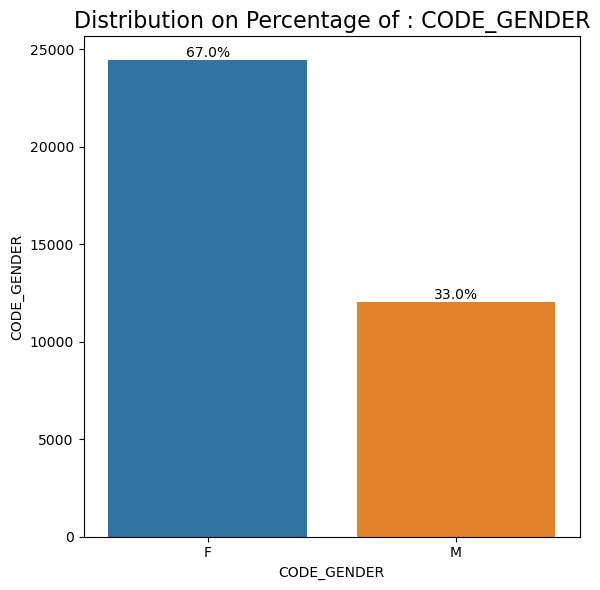

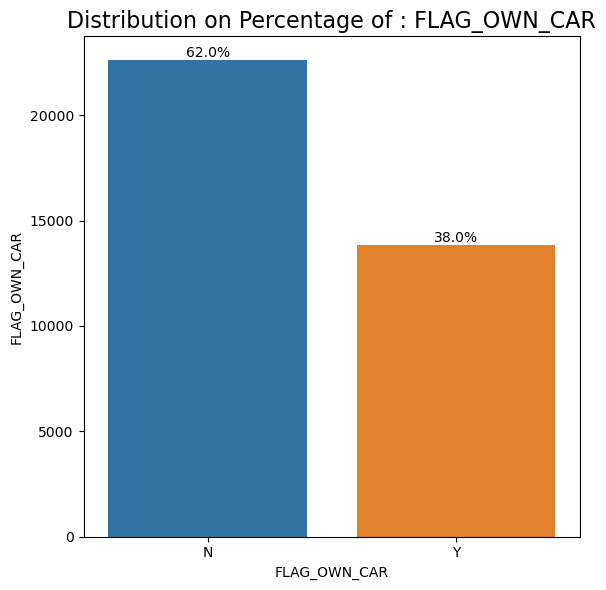

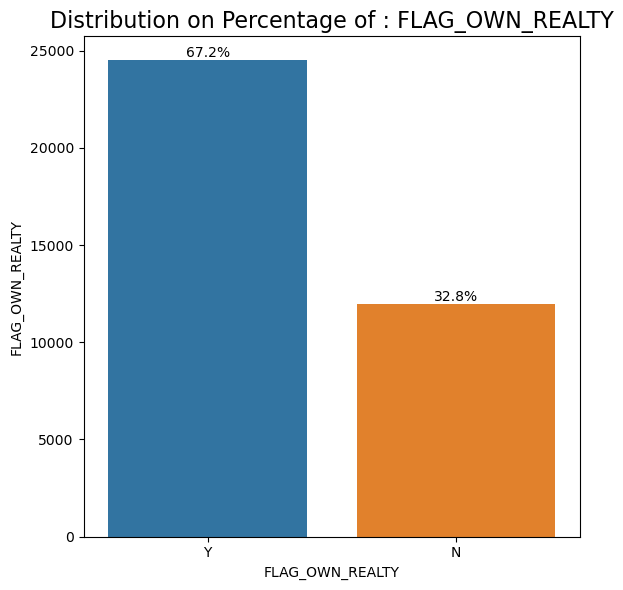

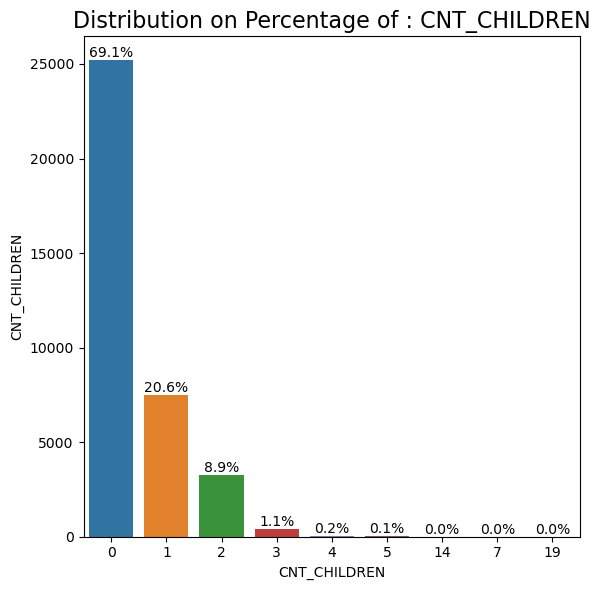

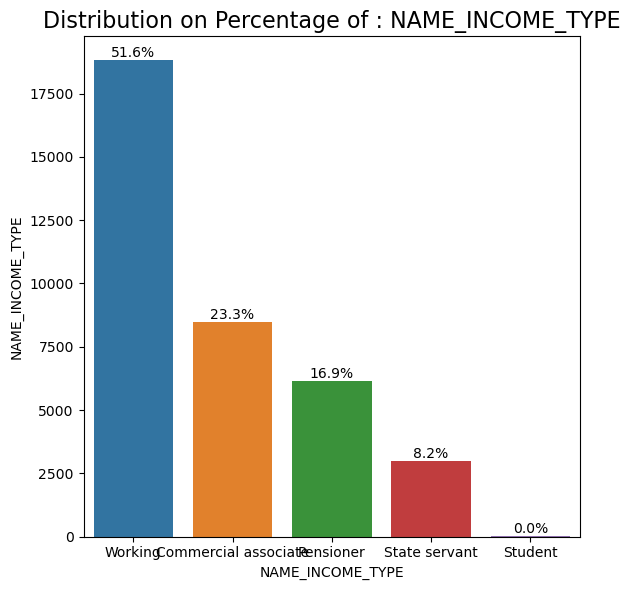

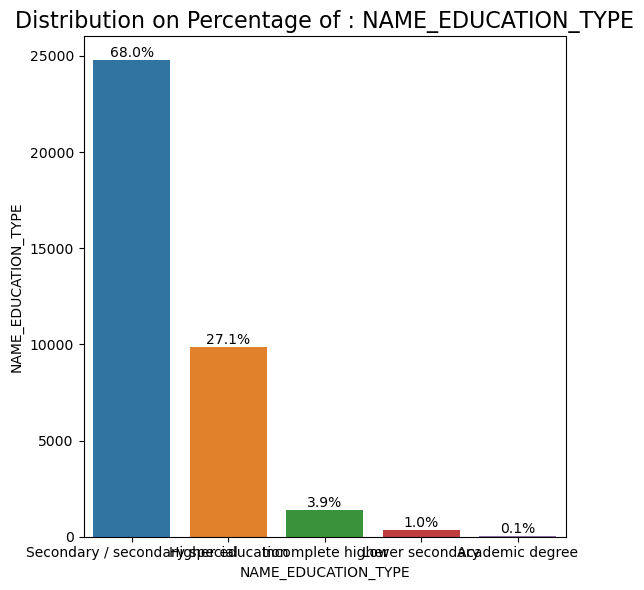

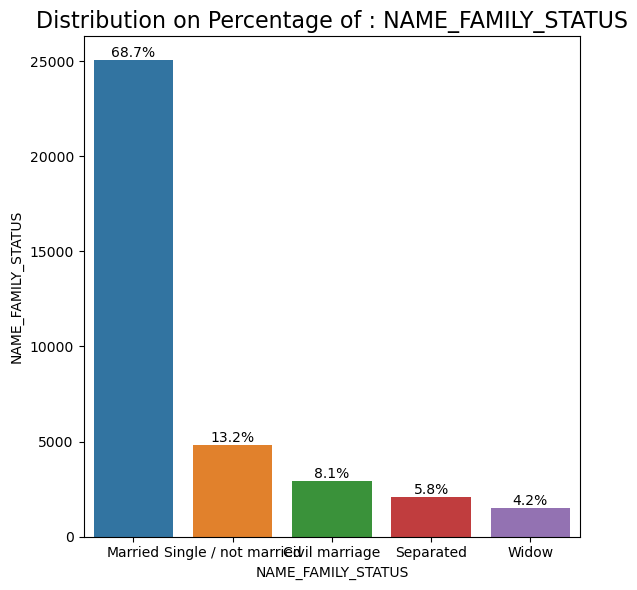

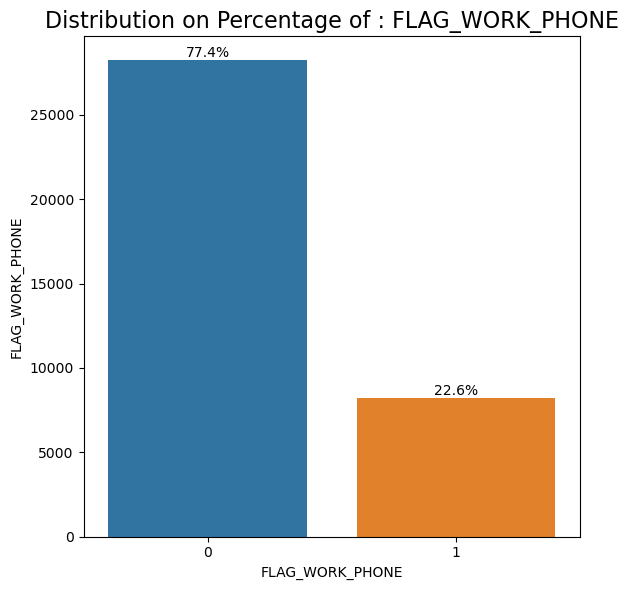

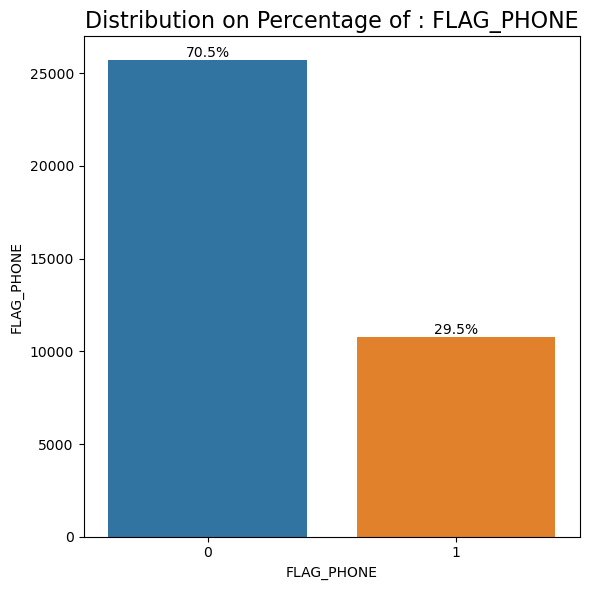

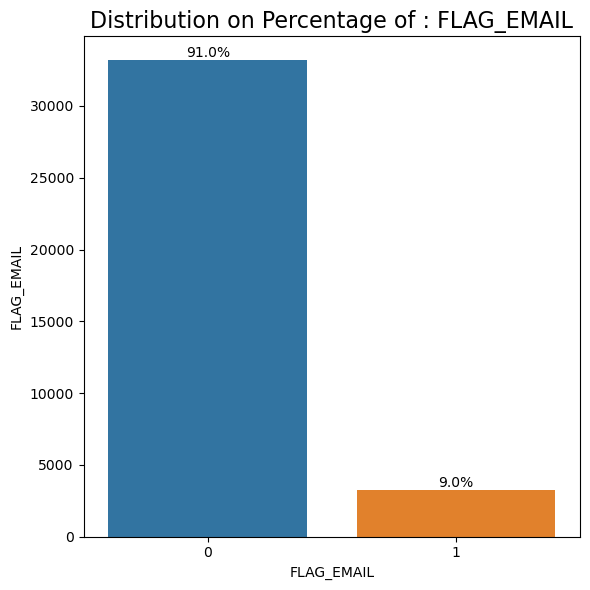

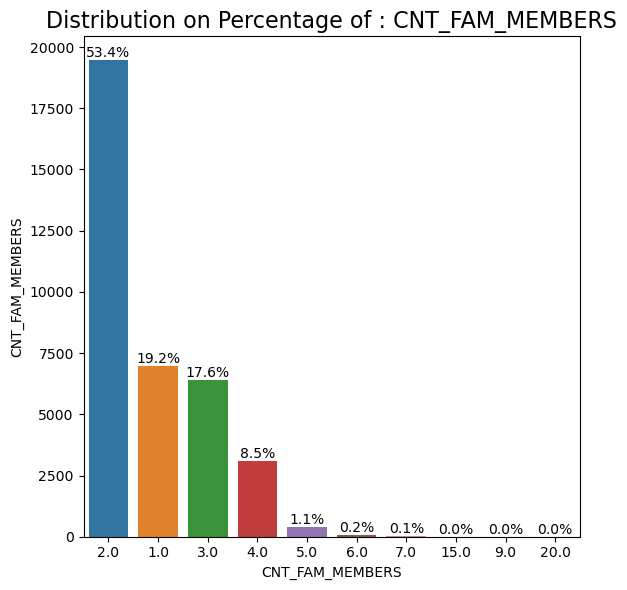

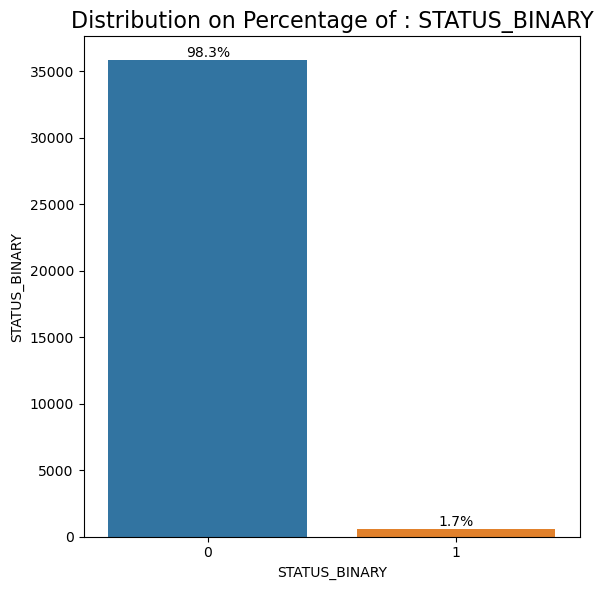

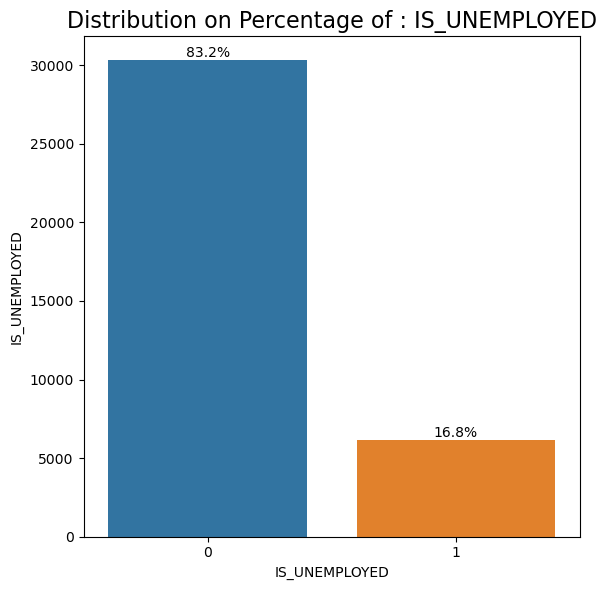

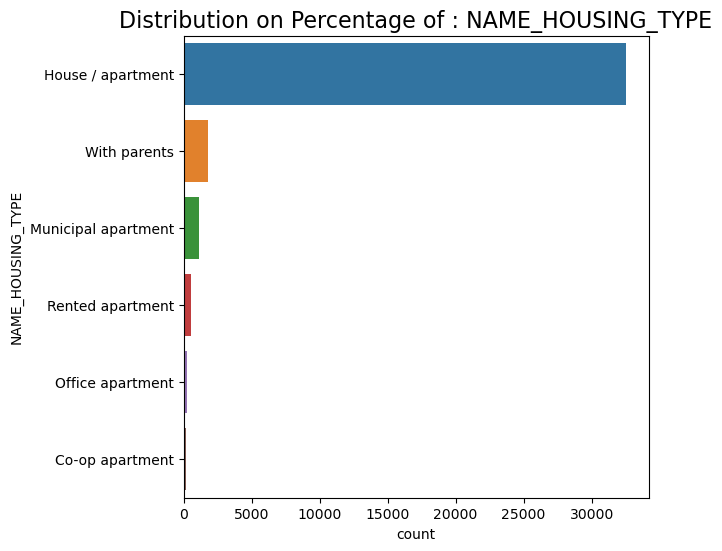

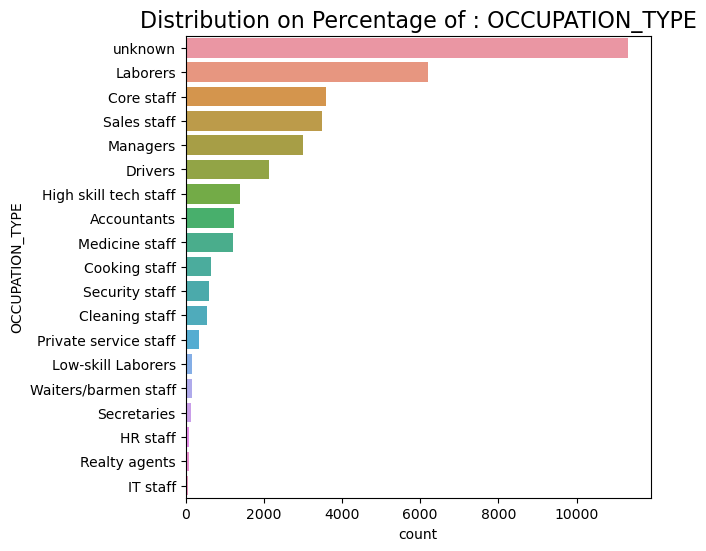

In [43]:
cols_to_exclude = ['ID', 'AGE_YEARS', 'YEARS_EMPLOYED', 'AMT_INCOME_TOTAL','OCCUPATION_TYPE','NAME_HOUSING_TYPE'] #here we select the columns we want to exclude from
#the plot, so the continous ones, and also occupation type because it has too many values so it will be done outside of the for loop
#when doing it we also saw that name housing had several names which are long so we can't read them when using columns graph so it will also be a lines one.
cols_to_plot = [col for col in df.columns if col not in cols_to_exclude]

total = len(df["ID"])

for col in cols_to_plot:
    plt.figure(figsize=(6, 6))
       
    ax = sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.ylabel(col)

    plt.title(f'Distribution on Percentage of : {col}', fontsize=16)
    for p in ax.patches:    #this loop is to put the % of repartition for each columns in the data set for exemple there is x% of M and y% of F
        height = p.get_height()
        percent = 100.0 * height / total
        ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

#doing NAME_HOUSING_TYPE on the y column because too long feature names
plt.figure(figsize=(6, 6))

p = sns.countplot(y='NAME_HOUSING_TYPE', data=df, order=df['NAME_HOUSING_TYPE'].value_counts().index)

plt.ylabel('NAME_HOUSING_TYPE')
plt.title(f'Distribution on Percentage of : {"NAME_HOUSING_TYPE"}', fontsize=16)
plt.show()

#doing OCCUPATION TYPE on the y column because too many values so need to make it readable
plt.figure(figsize=(6, 6))

p = sns.countplot(y='OCCUPATION_TYPE', data=df, order=df['OCCUPATION_TYPE'].value_counts().index)

plt.ylabel('OCCUPATION_TYPE')
plt.title(f'Distribution on Percentage of : {"OCCUPATION_TYPE"}', fontsize=16)
plt.show()


The first bar chart displays the distribution of the "CODE_GENDER" variable in the dataset. It shows a significant imbalance between the genders: the number of female cases (F) is notably higher, with nearly 25,000 entries, compared to about 12,000 male cases (M).

The second bar chart illustrates the distribution of the "FLAG_OWN_CAR" variable in the dataset. It reveals that the majority of individuals do not own a car, as indicated by the "N" category having a higher count (over 22,000), while the "Y" category (car owners) is notably lower, at around 14,000. This demonstrates an uneven split between car owners and non-owners, which may be relevant when analyzing or modeling patterns of credit card fraud

The third bar chart represents the distribution of the "FLAG_OWN_REALTY" variable in the dataset. It shows that a majority of individuals own real estate ("Y"), totaling nearly 25,000, while a much smaller group does not own real estate ("N"), with around 12,000 entries. This strong imbalance suggests that property ownership is common among the dataset population, which could be a relevant factor when modeling credit risk or analyzing fraud tendencies.

The fourth bar chart displays the distribution of the "CNT_CHILDREN" variable in the dataset. The majority of individuals have no children, as shown by the highest bar at zero, with declining frequencies for one and two children, and very few cases having three or more. This highly skewed distribution indicates that most people represented in the dataset either have no children or only one child, which may be a relevant demographic factor in credit risk or fraud detection analysis.

The fifth bar chart illustrates the distribution of the "NAME_INCOME_TYPE" variable in the dataset. The largest group by far consists of individuals with "Working" as their income type, followed by "Commercial associate," then "Pensioner" and "State servant." The "Student" category is nearly negligible. This distribution highlights the dominance of employed individuals among the loan applicants, with far fewer pensioners, state employees, or students, which may impact the types of credit risk or fraud patterns observed.

The sixth bar chart shows the distribution of the "NAME_EDUCATION_TYPE" variable in the dataset. The majority of individuals have "Secondary / secondary special" education, while "Higher education" makes up the second largest group. Much smaller proportions are seen for "Incomplete higher," "Lower secondary," and "Academic degree." This suggests that most people in the dataset have completed secondary-level education, with only a few holding advanced degrees, which may be relevant for understanding demographic trends in credit risk or fraudulent behavior.

The seventh bar chart presents the distribution of the "NAME_FAMILY_STATUS" variable from the dataset. The majority of individuals are "Married," with over 25,000 cases, while much smaller but notable groups include those who are "Single / not married," "Civil marriage," "Separated," and "Widow." This indicates that most loan applicants in the dataset are married, which can influence household dynamics and financial behavior relevant to credit and fraud analysis.

The 8th chart illustrates the distribution of the "FLAG_WORK_PHONE" variable in the dataset. The majority of individuals do not have a work phone (indicated by "0"), with over 27,000 cases, while a smaller group is indicated as having a work phone (indicated by "1"), with fewer than 9,000 cases. This highlights that most people in the dataset do not report having a work phone, which could be relevant when assessing job types or stability in relation to credit risk or fraudulent activity.

The 9th chart shows the distribution of the "FLAG_PHONE" variable in the dataset. Most individuals do not have a phone number registered (indicated by "0"), with about 26,000 cases, while around 11,000 have a phone number registered (indicated by "1"). This indicates a significant difference in phone availability among the dataset population, which could be an important factor in communication and verification processes related to credit or fraud cases.

The 10th bar chart displays the distribution of the "FLAG_EMAIL" variable in the dataset. An overwhelming majority of individuals do not have an email address registered (indicated by "0"), with over 32,000 cases, while a significantly smaller portion, about 3,000 cases, do have an email registered (indicated by "1"). This highlights that email contact information is relatively rare in the dataset, which may impact digital communication or verification processes for credit assessment and fraud prevention.

The 11th bar chart displays the distribution of the "CNT_FAM_MEMBERS" variable in the dataset. The most common family size is two members, followed by one and three members, with smaller numbers for larger family sizes such as four, five, and above. This suggests that most individuals in the dataset belong to small families, with a rapidly decreasing frequency for larger family units, which can be important for understanding financial dependency and credit risk profiles.

The 12th bar chart shows the distribution of the "STATUS_BINARY" variable, which indicates whether a client is considered "good" (0) or "not good" (1) in the credit card fraud dataset. The majority of clients fall into the "good" category, with more than 35,000 cases, while only a small portion, less than 2,000, are considered "not good." This class imbalance is important for credit scoring and fraud detection models, as it reflects that most clients in the dataset are viewed favorably by the lender. This implies that we will have to test resempling such as SMOTE.

The 13th bar chart displays the distribution of the "IS_UNEMPLOYED" variable in the dataset. The majority of individuals are employed (indicated by "0"), representing more than 30,000 entries, while a smaller segment is unemployed (indicated by "1"), with around 6,000 entries. This shows that most clients in the dataset are currently working, which is a key demographic characteristic likely to affect their creditworthiness and risk assessment.

The 14th chart represents the distribution of the "NAME_HOUSING_TYPE" variable in the dataset. The vast majority of individuals live in a "House / apartment," as shown by the highest bar by far, while much smaller groups reside "With parents," in "Municipal apartment," "Rented apartment," "Office apartment," or "Co-op apartment." This indicates that stable, conventional housing types dominate the dataset, which can influence the assessment of loan eligibility and fraud risk.

The last horizontal bar chart presents the distribution of the "OCCUPATION_TYPE" variable in the dataset. The largest group by far is those with an "unknown" occupation, followed by "Laborers," "Core staff," "Sales staff," and "Managers." Smaller occupational categories include "Drivers," "High skill tech staff," "Accountants," and numerous other roles, with "IT staff" being the least common. This breakdown highlights both a significant amount of missing occupation data and a workforce dominated by manual labor and basic staff positions, which is valuable for analyzing economic background and potential credit risk.

2nd step \
Now we are looking at the average count of the binary status for the same columns as previously to see which categrories are more likely to default.
The goal of this will be to see if there are some information that can make some people that fraud stand out, by comparing the average of the people who default with the average of the people with this particular information who default.


Default Rate (Average) of : 1.69%


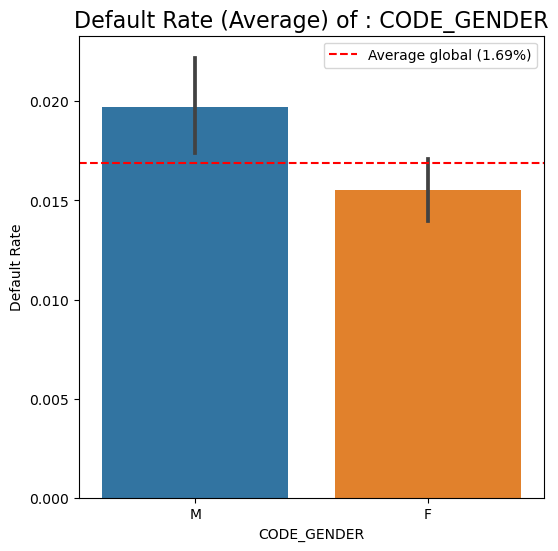

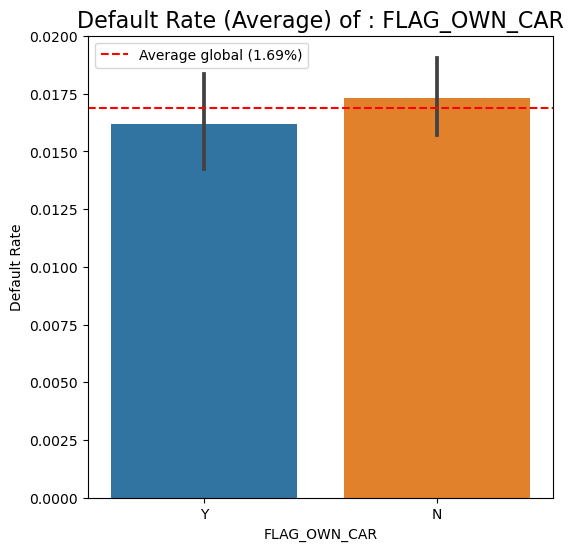

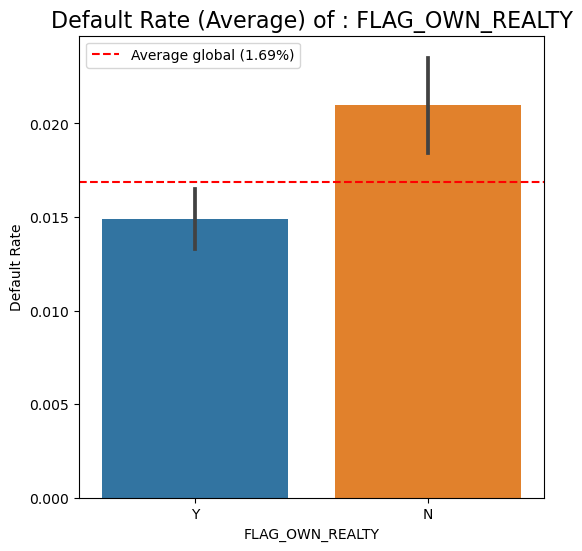

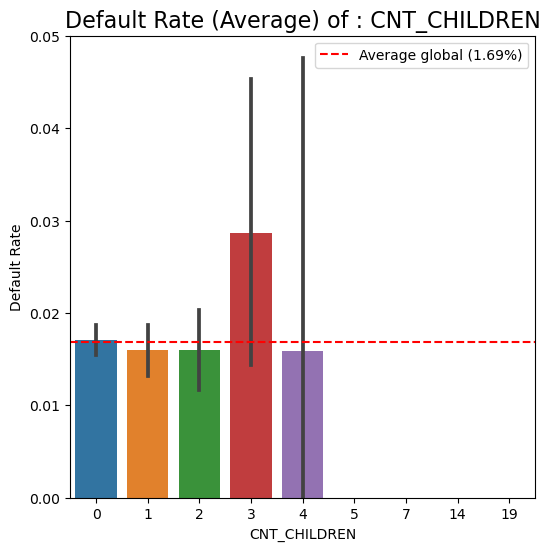

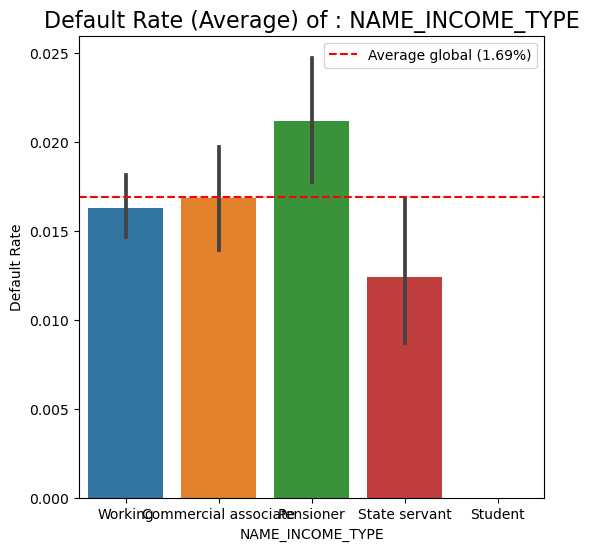

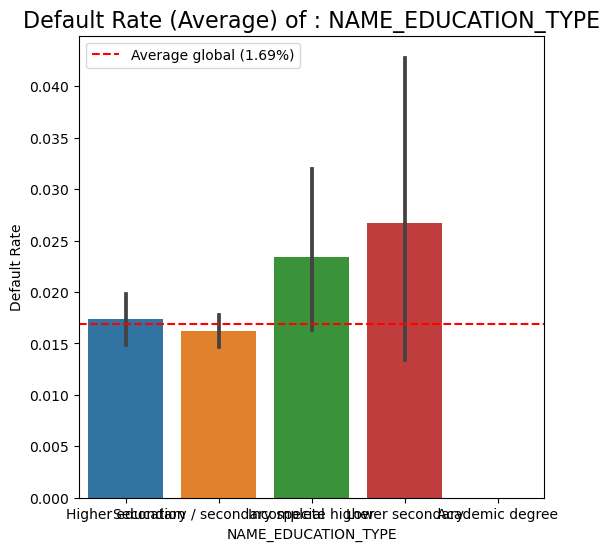

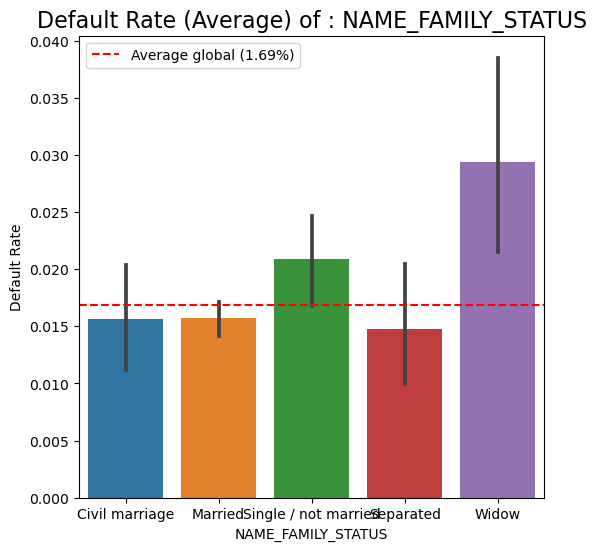

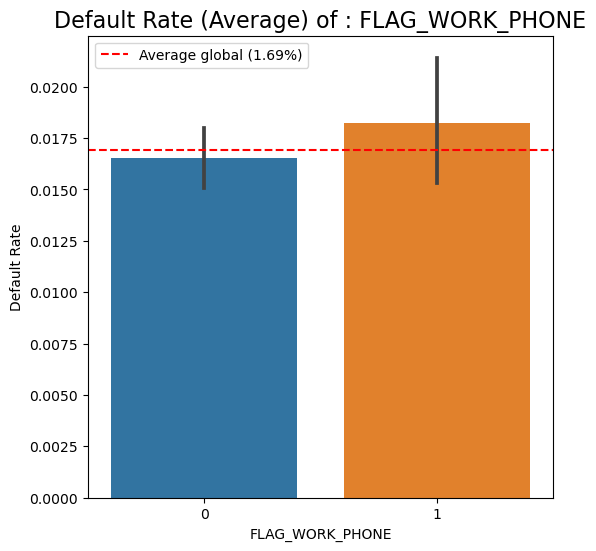

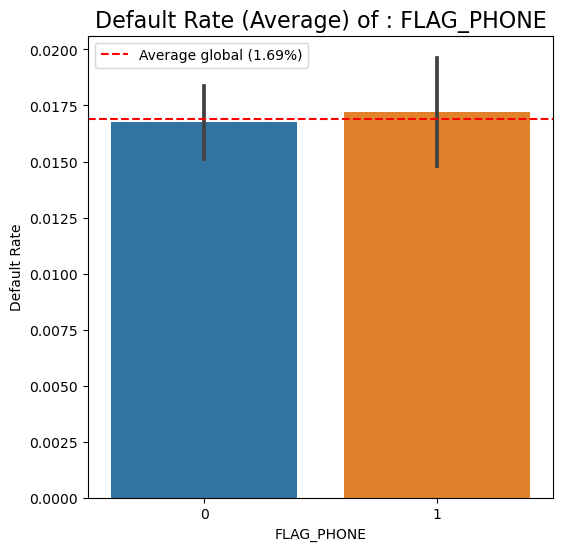

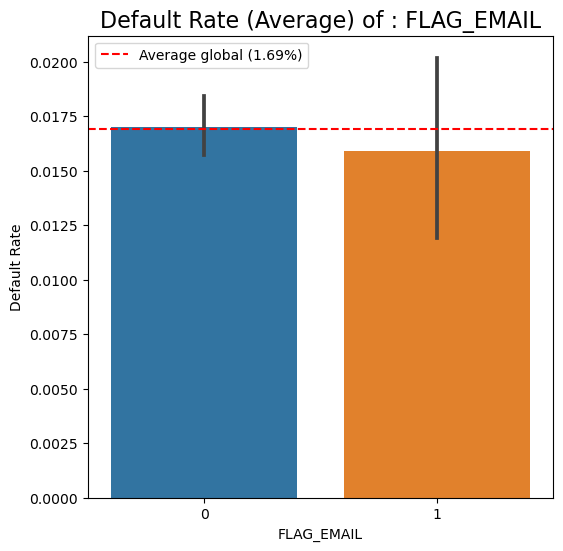

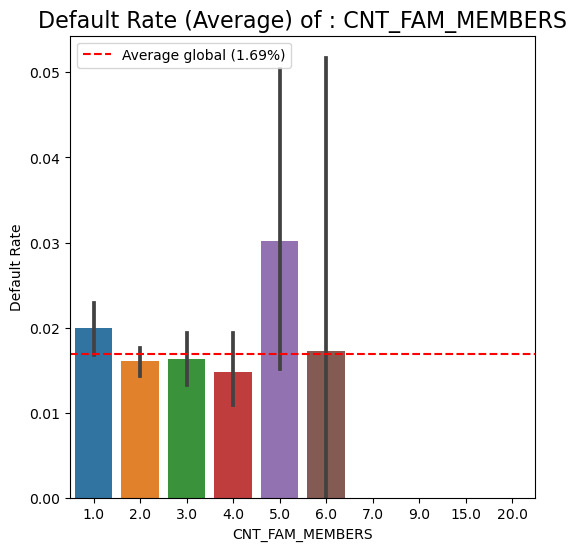

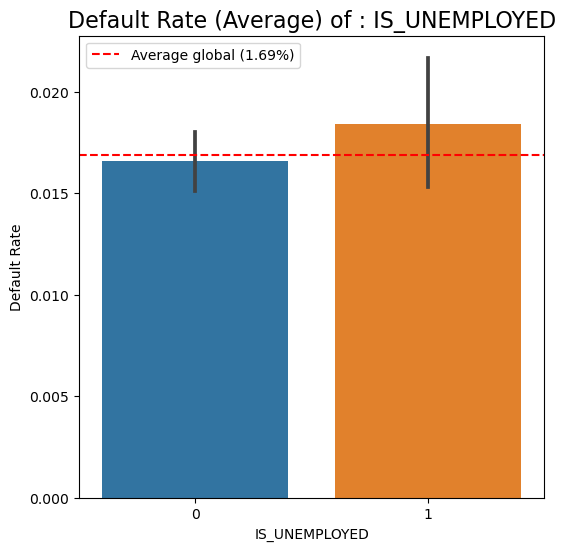

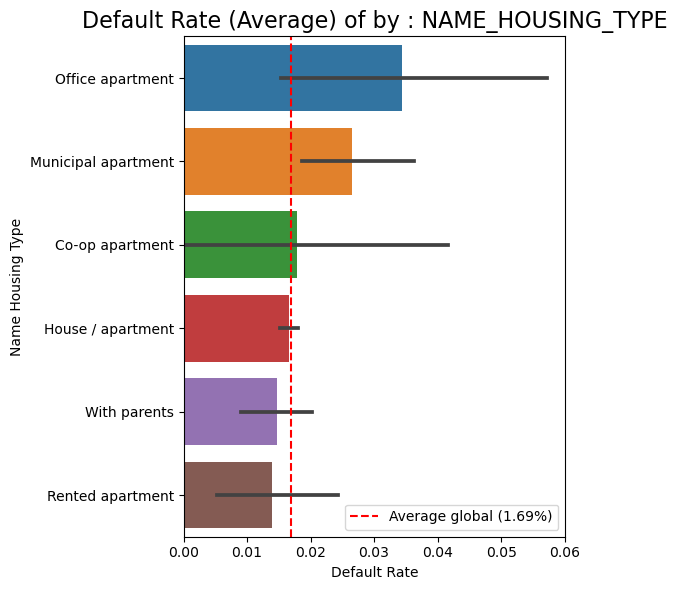

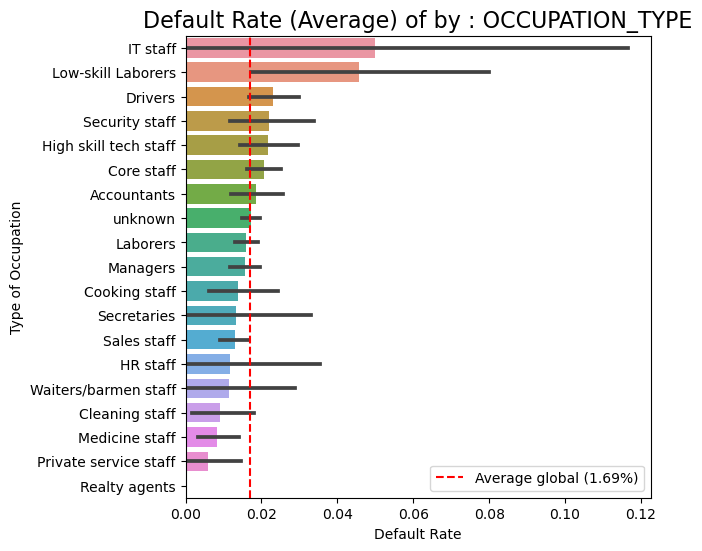

In [48]:
global_default_rate = df['STATUS_BINARY'].mean()
print(f"Default Rate (Average) of : {global_default_rate*100:.2f}%")

cols_to_plot = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
    'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
    'NAME_FAMILY_STATUS', 'FLAG_WORK_PHONE', 
    'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'IS_UNEMPLOYED'
]
#here instead of excluding we did it by selecting the columns we wanted, which will do the same, but it was too show a 2nd method. And for the same reason
#Occupation type and name housing type aren't part of the loop but still in the categorical analysis part. Also we didn't put status binary because it
#would not make sense

for col in cols_to_plot:
    plt.figure(figsize=(6, 6))
    
    # sns.barplot computes the avarage de 'BINARY_STATUS' for each 'col'
    ax = sns.barplot(x=col, y='STATUS_BINARY', data=df)
    
    # Add the line global average to compare
    ax.axhline(y=global_default_rate, color='red', linestyle='--', 
               label=f'Average global ({global_default_rate*100:.2f}%)')
    
    plt.title(f'Default Rate (Average) of : {col}', fontsize=16)
    plt.ylabel('Default Rate') 
    plt.xlabel(col)

    plt.legend()
    plt.show()

plt.figure(figsize=(6, 6))

# Order categories by avg default rate 
ordered_housing = (df.groupby('NAME_HOUSING_TYPE')['STATUS_BINARY'].mean().sort_values(ascending=False).index)

ax = sns.barplot(y='NAME_HOUSING_TYPE', x='STATUS_BINARY',data=df,order=ordered_housing)

# Add the line global average to compare
ax.axvline(x=global_default_rate,color='red',linestyle='--',label=f'Average global ({global_default_rate*100:.2f}%)')

plt.title(f'Default Rate (Average) of by : NAME_HOUSING_TYPE', fontsize=16)
plt.xlabel('Default Rate')
plt.ylabel('Name Housing Type')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 6))

ordered_categories = df.groupby('OCCUPATION_TYPE')['STATUS_BINARY'].mean().sort_values(ascending=False).index

ax = sns.barplot(y='OCCUPATION_TYPE', x='STATUS_BINARY', data=df, order=ordered_categories)

ax.axvline(x=global_default_rate, color='red', linestyle='--', 
           label=f'Average global ({global_default_rate*100:.2f}%)')

plt.title(f'Default Rate (Average) of by : OCCUPATION_TYPE', fontsize=16)
plt.xlabel('Default Rate')
plt.ylabel('Type of Occupation')
plt.legend()
plt.show()

The first bar chart compares the average default rate between male (M) and female (F) clients in the dataset. It shows that men have a higher average default rate than women, and the global average default rate (1.69%) is indicated by the dashed red line, which falls between the values for both genders. This visual makes it clear that gender is associated with slight differences in the likelihood of credit default.

The second bar chart compares the average default rate between clients who own a car ("Y") and those who do not ("N"). It shows that the default rate for clients without a car is slightly higher than for car owners, with both rates hovering near the global default rate of 1.69%. This suggests that car ownership is associated with a marginally lower likelihood of credit default in this dataset.

The third bar chart compares the average default rate between clients who own real estate ("Y") and those who do not ("N"). The results show that clients without real estate have a much higher default rate than those who own property, with the non-owners' rate also exceeding the global average default rate of 1.69%. This indicates that real estate ownership is associated with a lower risk of credit default in this dataset.

The fourth bar chart shows the average default rate for clients based on the number of children ("CNT_CHILDREN") they have. The default rate increases as the number of children grows, exceeding the global default rate (1.69%) for clients with three or more children and showing especially high variability among those with four or more. This suggests that having more children is linked to a higher risk of credit default in the dataset.

The fifth bar chart presents the average default rate for each income type ("NAME_INCOME_TYPE") in the dataset. Pensioners have the highest default rate, which is well above the global average default rate of 1.69%, while state servants display the lowest risk. Working clients and commercial associates fall between these extremes but remain close to or under the global average, and students are not represented. This suggests that income type is an important predictor of credit default risk.

The sixth bar chart displays the average default rate for each education level ("NAME_EDUCATION_TYPE") in the dataset. Clients with "Lower secondary" education show the highest default rate, clearly above the global average default rate of 1.69%, followed by those with "Incomplete higher" and other groups. In contrast, clients with "Higher education" and "Secondary/specialized secondary" have rates below or near the global average, indicating a pattern where lower education levels are linked to higher risk of credit default.

The seventh bar chart shows how the average default rate varies according to clients' family status ("NAME_FAMILY_STATUS"). Widowed clients have the highest default rate, well above the global average (1.69%), while those separated and married have the lowest rates, close to or below the global average. Clients who are single/not married or in civil marriage display intermediate default risks, suggesting marital status is related to credit default likelihood.

The 8th bar chart shows the average default rate for clients with and without a work phone ("FLAG_WORK_PHONE"). Clients who have a work phone (1) tend to have a slightly higher default rate than those who do not (0), with the "work phone" group's rate above the global average default rate of 1.69%. This suggests that, in this dataset, having a work phone is weakly associated with greater credit default risk.

The 9th bar chart compares the average default rate for clients who do and do not have a registered phone ("FLAG_PHONE"). Both groups have similar default rates, with clients possessing a phone (1) showing a slightly higher default rate than those without (0), and both rates positioned close to the global default rate of 1.69%. This suggests that registering a phone number has limited impact on credit default risk in this dataset.

The 10th bar chart displays the average default rate for clients based on whether they have an email registered ("FLAG_EMAIL"). Both groups have similar default rates, which are just below the global average of 1.69%, suggesting that having an email address on file does not significantly influence the risk of default in this dataset.

The 11th bar chart displays the average default rate according to family size ("CNT_FAM_MEMBERS"). Families with one to four members have rates close to the global average (1.69%), while families with five or more members show higher and more variable default rates. Generally, a larger family size is associated with a greater risk of credit default in the dataset.

The 12th bar chart shows the average default rate for clients based on employment status ("IS_UNEMPLOYED"). Unemployed clients (1) have a higher default rate than employed clients (0), and their rate is above the global average default rate of 1.69%. This demonstrates that unemployment is clearly associated with an increased risk of credit default in the dataset.

The 13th bar chart presents the average default rate for clients according to their type of housing ("NAME_HOUSING_TYPE"). Clients living in "Office apartment" have the highest default rate, far above the global average of 1.69%, followed by those in "Municipal apartment" and "Co-op apartment". In contrast, those living in "Rented apartment" or "With parents" show lower default rates. This indicates that certain housing types, especially less common ones, are associated with a significantly higher credit default risk.

The last horizontal bar chart shows the average default rate for each occupation type ("OCCUPATION_TYPE"). The "IT staff" and "Low-skill Laborers" have the highest default rates—far above the global average of 1.69% while "Realty agents," "Private service staff," and "Cleaning staff" appear to have the lowest risks. The chart highlights considerable variability in credit default risk across different jobs, with some groups (like IT staff) standing out as especially high risk in this dataset.

Continuous features visualisations

Numerical columns : ['AMT_INCOME_TOTAL', 'AGE_YEARS', 'YEARS_EMPLOYED']


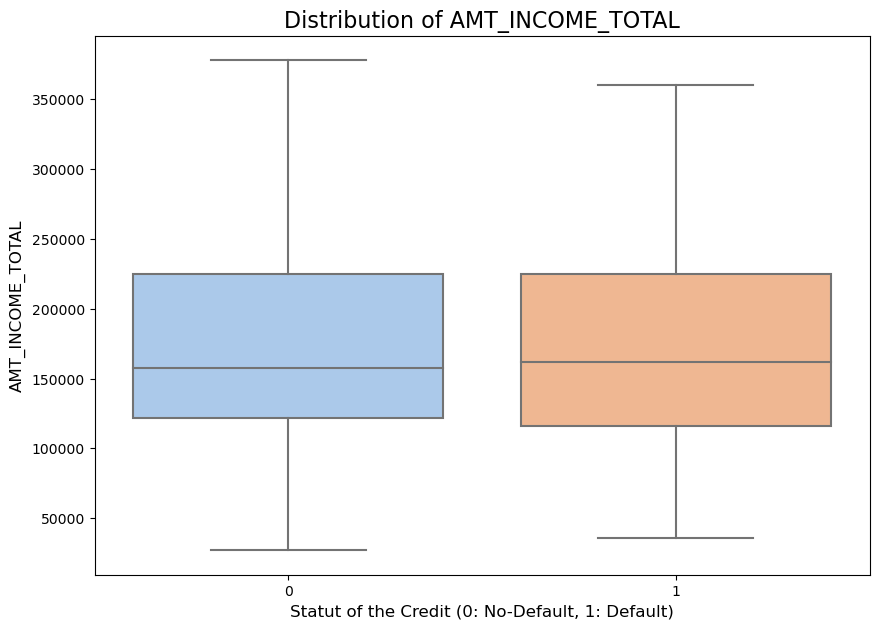

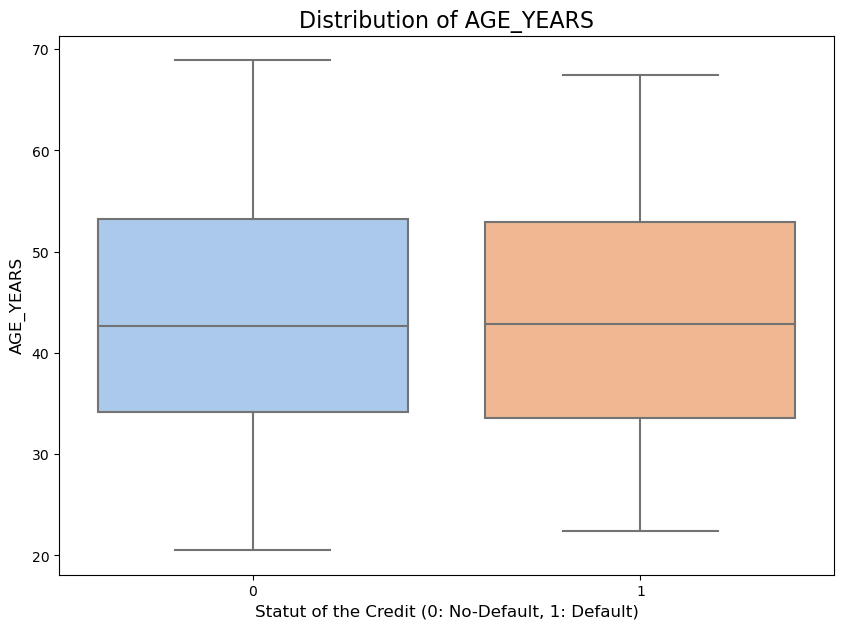

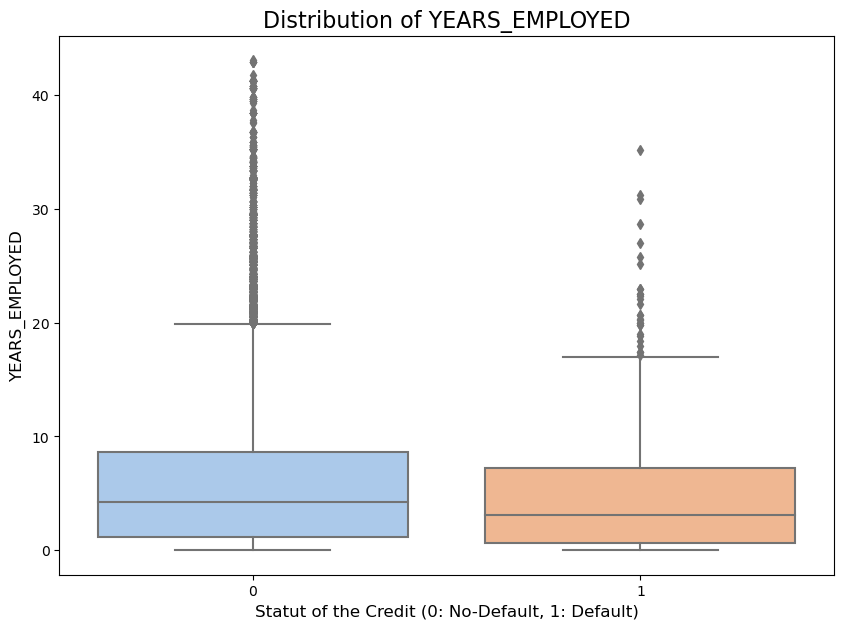

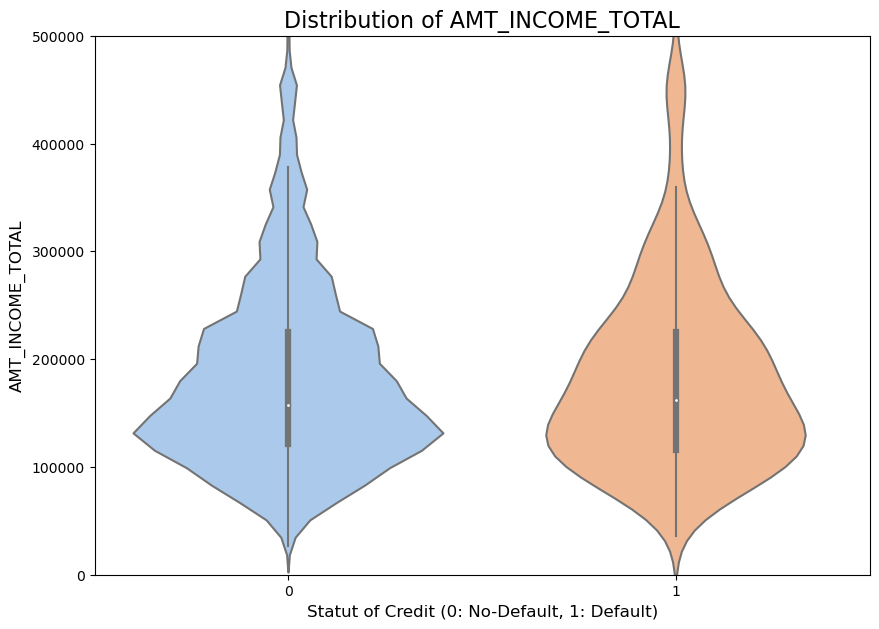

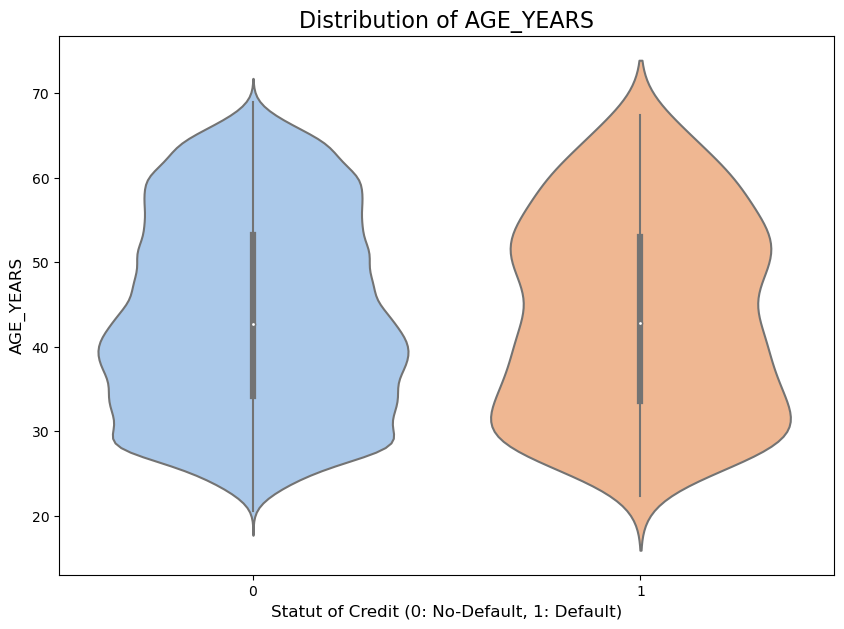

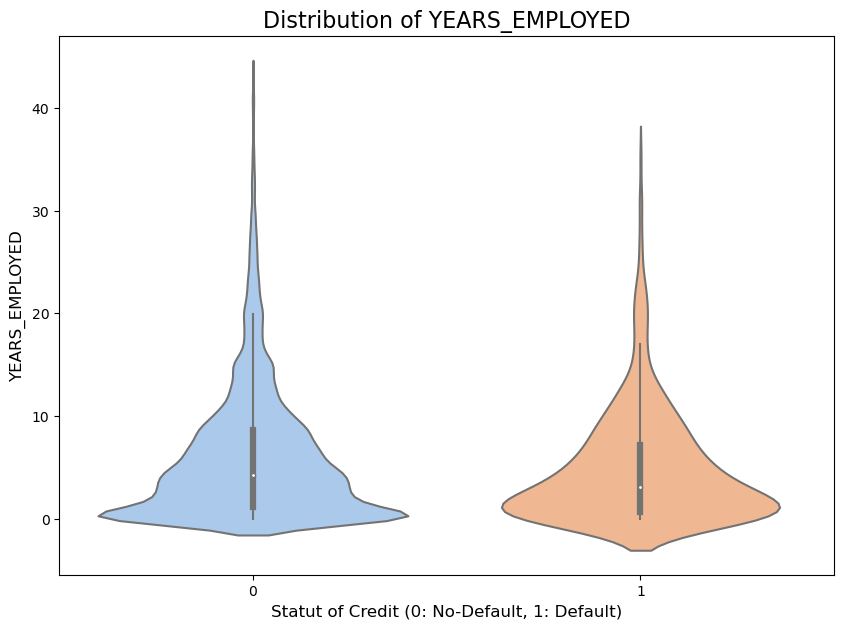

In [51]:
# now let's look at the column we left aside previously
numerical_cols = ['AMT_INCOME_TOTAL', 'AGE_YEARS', 'YEARS_EMPLOYED']
print(f"Numerical columns : {numerical_cols}")

# Boxplots

for col in numerical_cols:
    plt.figure(figsize=(10, 7))
    
    if col == 'AMT_INCOME_TOTAL':
        # we hide the outliers because there is too many (with showfliers)
        ax = sns.boxplot(x='STATUS_BINARY', y=col, data=df, palette="pastel", showfliers=False)
        ax.set_title(f'Distribution of {col}', fontsize=16)
    else:
        ax = sns.boxplot(x='STATUS_BINARY', y=col, data=df, palette="pastel", showfliers=True)
        ax.set_title(f'Distribution of {col}', fontsize=16)

    plt.xlabel('Statut of the Credit (0: No-Default, 1: Default)', fontsize=12)
    plt.ylabel(col, fontsize=12)
    
    plt.show()


for col in numerical_cols:
    plt.figure(figsize=(10, 7))
    
    if col == 'AMT_INCOME_TOTAL':
        ax = sns.violinplot(x='STATUS_BINARY', y=col, data=df, palette="pastel")
        ax.set_ylim(0, 500000) #we do a zoom else there is few high values that makes it less visible
        ax.set_title(f'Distribution of {col}', fontsize=16)
    else:
        ax = sns.violinplot(x='STATUS_BINARY', y=col, data=df, palette="pastel")
        ax.set_title(f'Distribution of {col}', fontsize=16)

    plt.xlabel('Statut of Credit (0: No-Default, 1: Default)', fontsize=12)
    plt.ylabel(col, fontsize=12)
    
    plt.show()

The first boxplot shows the distribution of total income ("AMT_INCOME_TOTAL") for clients with different credit statuses: non-default (0) and default (1). The median and spread of income are very similar for both groups, meaning that the income distribution does not substantially differ between clients who defaulted and those who did not. This suggests that total income alone is not a strong indicator of default risk in this dataset.

The second boxplot illustrates the distribution of ages ("AGE_YEARS") for both non-defaulted (0) and defaulted (1) credit clients. The age distribution is very similar in both groups, with nearly identical medians and spreads, indicating that age does not significantly distinguish between default and non-default clients in this dataset.

The third boxplot shows the distribution of years of employment ("YEARS_EMPLOYED") for non-defaulted (0) and defaulted (1) clients. Clients who defaulted generally have fewer years of employment, with a lower median and slightly less spread than those who did not default. This suggests that shorter employment histories are associated with a higher risk of credit default in the dataset.

The first violin plot displays the distribution of total income ("AMT_INCOME_TOTAL") for non-defaulted (0) and defaulted (1) clients. The shapes, spreads, and medians are highly similar for both groups, confirming that income distributions are almost identical regardless of default status. This suggests that other factors may be more useful than income for distinguishing clients who defaulted versus those who did not.

The second violin plot shows the age distribution ("AGE_YEARS") for non-defaulted (0) and defaulted (1) credit clients. Both groups have almost identical distributions, similar shapes, medians, and spreads, indicating that age is not a major distinguishing factor between those who defaulted and those who did not in this dataset.

The third violin plot displays the distribution of years of employment ("YEARS_EMPLOYED") for non-defaulted (0) and defaulted (1) clients. The plot shows that defaulted clients generally have fewer years at their current job, with a lower median and overall shorter employment histories compared to non-defaulted clients. This visualization suggests that shorter employment duration is linked to higher credit default risk in the dataset.

Feature Engineering Strategy and removing redundants variables (like married and civil marriage become married)



In [50]:
# Create a copy to avoid to keep the original dataframe intact if we want to change back some part of the encoding or add back something
df_encod=df.copy()

# Merging 'Civil marriage' into 'Married' as they are basically the same
df_encod['NAME_FAMILY_STATUS'] = df_encod['NAME_FAMILY_STATUS'].replace({'Civil marriage': 'Married'})
print(f"Family status. New values : {df_encod['NAME_FAMILY_STATUS'].unique()}") #to check if it worked

# This prevents the model from overfitting to noise found in underrepresented categories.
df_encod['NAME_EDUCATION_TYPE'] = df_encod['NAME_EDUCATION_TYPE'].replace({
    'Incomplete higher': 'Other_Education',
    'Lower secondary': 'Other_Education',
    'Academic degree': 'Other_Education'
})
# Values >= 4 are outliers and could skew the model. And similary >=6 for fam members.
df_encod['CNT_CHILDREN_CAT'] = df_encod['CNT_CHILDREN'].apply(lambda x: 4 if x >= 4 else x).astype(str)
df_encod['CNT_FAM_MEMBERS_CAT'] = df_encod['CNT_FAM_MEMBERS'].apply(lambda x: 6 if x >= 6 else x).astype(str)

# Commercial associate and State servant are grouped with 'Working' 
# as they all represent active employment status.
df_encod['NAME_EDUCATION_TYPE'] = df_encod['NAME_EDUCATION_TYPE'].replace({
    'Commercial associate': 'Working',
    'State servant': 'Working'})


df_encod = df_encod.drop(columns=['CNT_CHILDREN', 'CNT_FAM_MEMBERS'])

#not used because it gave worst results
#top_10_occupations = df_encod['OCCUPATION_TYPE'].value_counts().nlargest(10).index
#df_encod['OCCUPATION_TYPE_CAT'] = df_encod['OCCUPATION_TYPE'].apply(lambda x: x if x in top_10_occupations else 'Other_Occupation')
#df_encod = df_encod.drop(columns=['OCCUPATION_TYPE'])

Family status. New values : ['Married' 'Single / not married' 'Separated' 'Widow']


Categorical Consolidation: We grouped redundant values (e.g., Civil marriage to Married) and merged rare categories (e.g., Academic degree) into a generic "Other" group. This reduces high cardinality and prevents the model from overfitting to statistical noise.


Discretization & Outlier Handling: Variables like child count contained outliers. We capped there values and converted them to categorical strings. This mitigates the impact of extreme values and allows the model to treat large families as a distinct risk profile

# 3. Split and Scale/Encode

We do the split and now we need to decide what type of encoding to use between, pd.dummies, OneHotEncoder, LabelEncoder, OrdinalEncoder (the last 2 need a logic order which we don't have here so we won't use them for now and dummies have some risk to create some issues with the number of columns if there are some variables almost not represented) so for now we will use OneHotEncoder



In [55]:
# Separating the target variable (y) from the features (X)
y=df_encod["STATUS_BINARY"]
X=df_encod.drop(columns=["STATUS_BINARY","ID"]) # ID is removed as it has no predictive value

# Splitting the dataset into training 80% and testing 20% sets
# We use 'stratify=y' to ensure the proportion of fraud cases is the same between train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print(f"Separated data : {X_train.shape[0]} Train data, {X_test.shape[0]} Test data")

#we take the num and cate cols to then scale and encode them
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'string']).columns

print(f"Numerical Columns (need Scaling) : {list(numerical_cols)}")
print(f"Categorical Columns (need encoding) : {list(categorical_cols)}")

# StandardScaler for numerical data Standardizes features by removing the mean and scaling to unit variance
numeric_transformer = StandardScaler()
# OneHotEncoder for categorical data: Converts categories into binary columns
# 'handle_unknown=ignore' ensures the model won't crash if the test set contains a rare category not seen during training
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
# Applying the preprocessing:
# FIT & TRANSFORM on Training data The scaler learns the mean/std and the encoder learns categories from Train data.
X_train_processed = preprocessor.fit_transform(X_train)

# TRANSFORM ONLY on Test data: We use the mean/std and categories learned from Train.
# This prevents Data Leakage
X_test_processed = preprocessor.transform(X_test)



Separated data : 29165 Train data, 7292 Test data
Numerical Columns (need Scaling) : ['AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'AGE_YEARS', 'YEARS_EMPLOYED']
Categorical Columns (need encoding) : ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'CNT_CHILDREN_CAT', 'CNT_FAM_MEMBERS_CAT']


Our dataset have a major class imbalance, with the minority class (defaults) representing only ~1.7% of the data. Standard machine learning algorithms tend to favor the majority class, often ignoring the minority class entirely to maximize overall accuracy . To address this, we employed a resampling technique.


SMOTE (Synthetic Minority Over-sampling Technique) Instead of simple random oversampling, which duplicates existing records and can lead to overfitting, we used SMOTE. This technique generates synthetic examples for the minority class by interpolating between existing samples . This enriches the decision boundary and helps the model generalize better to unseen fraud cases.

Prevention of Data Leakage We applied SMOTE exclusively to the training set. The testing set remains untouched and imbalanced. This distinction is crucial:

Training : The model learns on a new data set that is balanced with a 50/50 distribution, preventing it from being biased on the majority class

Testing: We evaluate the model on the original real world data that has an imbalanced distribution. This ensures our performance metrics (Precision, Recall, F1) to reflect our model's true ability to detect fraud with real world data. Applying SMOTE to the test set would make fake data, and data leakage giving optimistic results.

In [58]:
### Initialize SMOTE with a fixed random state for reproducibility.
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data ONLY.
# We must never oversample the test set because it needs to remain a true represenation of the real world distribution 
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(f"\nTraining set shape (before SMOTE): {X_train_processed.shape}")
print(f"Class distribution (before SMOTE): {Counter(y_train)}")

print(f"\nTraining set shape (after SMOTE): {X_train_smote.shape}")
print(f"Class distribution (after SMOTE): {Counter(y_train_smote)}")


Training set shape (before SMOTE): (29165, 60)
Class distribution (before SMOTE): Counter({0: 28672, 1: 493})

Training set shape (after SMOTE): (57344, 60)
Class distribution (after SMOTE): Counter({0: 28672, 1: 28672})


# 4. Model Testing (with and without SMOTE)

Let's test a first model, basic classifier one for now that is interpretable the DecisionTreeClassifier. And then we will try a regression one to see what would work the best

We evaluate the model on the original, imbalanced test set (X_test_processed). We rely on the Confusion Matrix and the Classification Report rather than accuracy. Our primary focus is on the Recall of Class 1, which indicates the percentage of actual defaulters correctly identified by the model .


--- Report of Classification ---
                      precision    recall  f1-score   support

Class 0 (No Default)       0.99      0.99      0.99      7169
   Class 1 (Default)       0.25      0.27      0.26       123

            accuracy                           0.97      7292
           macro avg       0.62      0.63      0.62      7292
        weighted avg       0.97      0.97      0.97      7292


--- Confusion Matrix---
[[7070   99]
 [  90   33]]


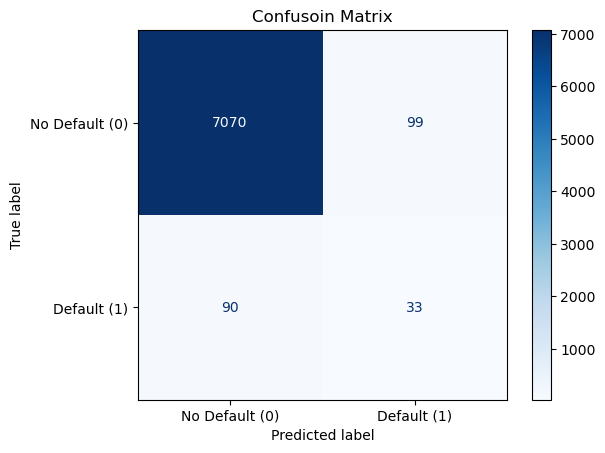

In [31]:
# We initialize a Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=100, random_state=42) #put a max depth to prevent overfitting

# We fit the model on the SMOTE training set
dt_model.fit(X_train_smote, y_train_smote)

# We evaluate the model on the processed test set
y_pred = dt_model.predict(X_test_processed)
print("\n--- Report of Classification ---")

# This is what we use to evaluate a model (it contains recall, f1, precision)
print(classification_report(y_test, y_pred, target_names=['Class 0 (No Default)', 'Class 1 (Default)']))

print("\n--- Confusion Matrix---")
# The confusion matrix shows the counts of True Positives, True Negatives, False Positives, and False Negatives
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Display graphic of the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['No Default (0)', 'Default (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusoin Matrix")
plt.show()

The results for the Decision Tree classifier trained on SMOTE data reveal a recall of 0.27 for the default class, meaning the model only correctly identifies roughly one-quarter of the actual defaults. While the precision is significantly better than a random guess at 0.25, the low f1-score of 0.26 suggests the model struggles to capture the complexity of the minority class effectively. Despite a high overall accuracy of 0.97, the confusion matrix exposes a critical weakness where 90 out of 123 true defaults are missed, which constitutes a major financial risk

We are now going to try a Regression model to see how they handle this imbalancement


--- Report of Classification (logistic regression) ---
                      precision    recall  f1-score   support

Class 0 (Non-Défaut)       0.99      0.58      0.73      7169
    Class 1 (Défaut)       0.02      0.50      0.04       123

            accuracy                           0.58      7292
           macro avg       0.50      0.54      0.38      7292
        weighted avg       0.97      0.58      0.72      7292

Confusion matrix (logistic regression):
[[4159 3010]
 [  61   62]]


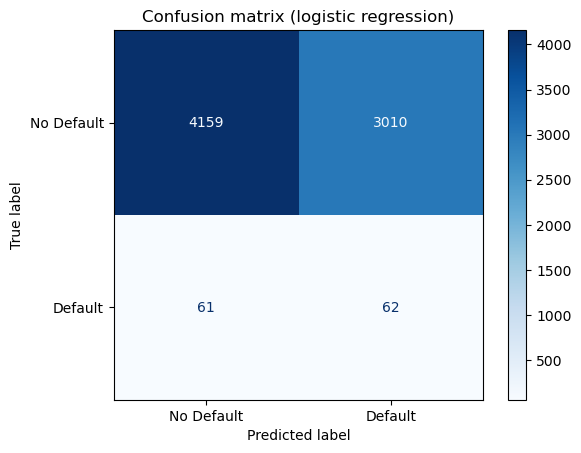

In [33]:
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

# training with the smote data
log_reg_model.fit(X_train_smote, y_train_smote)

# Evaluation on the processed test set
y_pred_log_reg = log_reg_model.predict(X_test_processed)

print("\n--- Report of Classification (logistic regression) ---")
print(classification_report(y_test, y_pred_log_reg, target_names=['Class 0 (Non-Défaut)', 'Class 1 (Défaut)']))

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("Confusion matrix (logistic regression):")
print(cm_log_reg)

# display
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=['No Default', 'Default'])
disp_log_reg.plot(cmap='Blues', values_format='d')
plt.title("Confusion matrix (logistic regression)")
plt.show()

Those results for logistic regression after applying SMOTE show that the model achieves a recall of 0.50 for the default class, meaning it correctly identifies half of actual defaults, but the precision for defaults is extremely low (0.02), leading to a very low f1-score. The model sacrifices overall accuracy (0.58) to detect more defaults, as shown in the confusion matrix: out of 123 true defaults, 62 are found, but 3009 non-default cases are misclassified as defaults which is too much to be consider viable even though it gets a 50% recall. The high false-positive rate for defaults indicates that the model now over-predicts defaults at the cost of accuracy and precision.

To address the instability and high variance observed in the single Decision Tree, we implemented a Random Forest Classifier. This ensemble method constructs multiple decision trees during training and outputs the class selected by the majority of the trees (Bagging), effectively reducing the risk of overfitting


--- Classification Report (Random Forest) ---
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.99      0.99      0.99      7169
    Class 1 (Default)       0.29      0.24      0.27       123

             accuracy                           0.98      7292
            macro avg       0.64      0.62      0.63      7292
         weighted avg       0.98      0.98      0.98      7292

Confusion Matrix (Random Forest):
[[7096   73]
 [  93   30]]


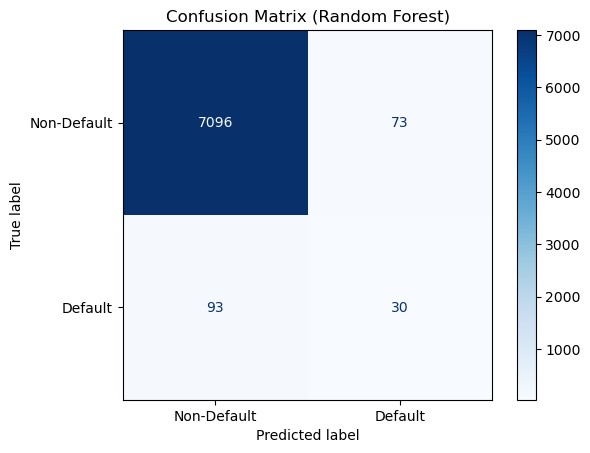

In [35]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100) 

# Training on SMOTE data
rf_model.fit(X_train_smote, y_train_smote)

# Evaluation on the Test set
y_pred_rf = rf_model.predict(X_test_processed)

print("\n--- Classification Report (Random Forest) ---")
print(classification_report(y_test, y_pred_rf, target_names=['Class 0 (Non-Default)', 'Class 1 (Default)']))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)

#display
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Non-Default', 'Default'])
disp_rf.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Random Forest)")
plt.show()


Precision (0.29): This is the model's main improvement. By averaging multiple trees, the Random Forest filtered out some of the noise, reducing the number of False Positives to 73 (down from 99). When it flags a customer as a defaulter, it is slightly more likely to be correct.

Recall (0.24): This is the model's critical weakness. It identified only 30 out of 123 actual defaults. Surprisingly, this is slightly lower than the single Decision Tree. The "smoothing" effect of the ensemble seems to have washed out some of the weaker signals identifying the minority class.

So bagging alone isn't sufficient

**Weight instead of SMOTE**
In this step, we shift our strategy from data-level handling of imbalance (SMOTE) to algorithm-level handling. Instead of generating synthetic data, we train the Random Forest on the original, imbalanced dataset (X_train_processed) but instruct the model to penalize errors on the minority class more heavily

**Grid Search**
Grid Search is an optimization technique used to find the best combination of hyperparameters for a model.
It takes a "grid" of parameters we want to test (e.g., n_estimators: 100 or 200, max_depth: 10 or 20).
It exhaustively trains a new model for every possible combination of these parameters.
For each combination, it uses Cross-Validation (splitting the training data into 3 folds) to evaluate performance.
Finally, it retains the model that achieved the highest score (in our case, the best F1-Score).


Starting GridSearchCV
Fitting 3 folds for each of 16 candidates, totalling 48 fits
GridSearchCV completed.

The best parameters found are:
{'class_weight': {0: 1.0, 1: 58.15821501014199}, 'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}

Evaluating the 'Best Estimator' on the Test set

--- Classification Report (Best RF, without SMOTE) ---
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.99      0.97      0.98      7169
    Class 1 (Default)       0.16      0.37      0.22       123

             accuracy                           0.96      7292
            macro avg       0.58      0.67      0.60      7292
         weighted avg       0.97      0.96      0.97      7292

Confusion Matrix (Best RF, without SMOTE):
[[6935  234]
 [  78   45]]


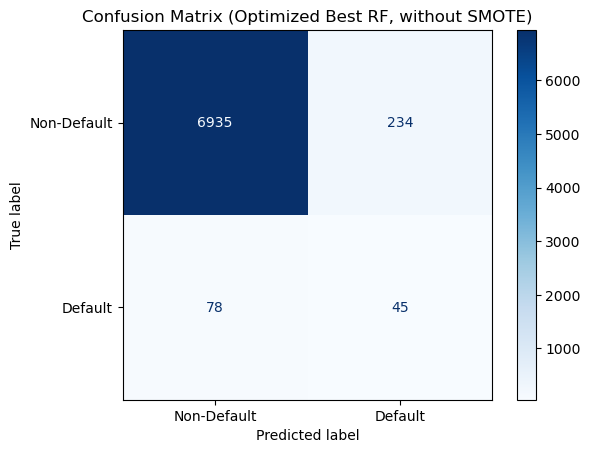

In [340]:
# We are now going to try to use a grid to find the best one
counts = Counter(y_train)
scale_pos_weight = counts[0] / counts[1]
param_grid = {
    'n_estimators': [100, 200],         
    'max_depth': [10, 20],              
    'min_samples_leaf': [5, 10],        
    'class_weight': [{0: 1.0, 1: scale_pos_weight}, 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='f1', # it is to maximize recall without neglecting accuracy
                           n_jobs=-1,
                           verbose=2)


grid_search.fit(X_train_processed, y_train)

print(f"\nThe best parameters found are:")
print(grid_search.best_params_)

#Getting the Best Estimator on the Test set"
best_rf_model = grid_search.best_estimator_

# Prediction on the test set
y_pred_best_rf = best_rf_model.predict(X_test_processed)

print("\n--- Classification Report (Best RF, without SMOTE) ---")
print(classification_report(y_test, y_pred_best_rf, target_names=['Class 0 (Non-Default)', 'Class 1 (Default)']))

cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
print("Confusion Matrix (Best RF, without SMOTE):")
print(cm_best_rf)

#display
disp_best_rf = ConfusionMatrixDisplay(confusion_matrix=cm_best_rf, display_labels=['Non-Default', 'Default'])
disp_best_rf.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Optimized Best RF, without SMOTE)")
plt.show()

The optimized Random Forest without SMOTE and using grid search and a class weight achieves very high precision and recall for the majority class (“Non-Défaut”), but minority class (“Défaut”) detection remains limited: only 37% of actual defaults are identified, which is great improvment from previous Decision tree and classic random forest, since we found 45 default instead of 30 so a 50% increase, and the F1-score for defaults is 0.22, with many defaults still misclassified as non-defaults; overall accuracy sits at 0.96.

Let's try to apply a k-nearest-neighbours algorithm and then try to optimize it with the best parameters.

In [60]:
knn_model = KNeighborsClassifier(
    n_neighbors=5,       
    weights="uniform",  
    metric="minkowski"  
)
# Train on SMOTE-resampled training data
knn_model.fit(X_train_smote, y_train_smote)


KNeighborsClassifier()


--- Classification Report (K-Nearest Neighbors) ---
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.99      0.96      0.97      7169
    Class 1 (Default)       0.10      0.28      0.15       123

             accuracy                           0.95      7292
            macro avg       0.54      0.62      0.56      7292
         weighted avg       0.97      0.95      0.96      7292

Confusion Matrix (K-Nearest Neighbors):
[[6860  309]
 [  89   34]]


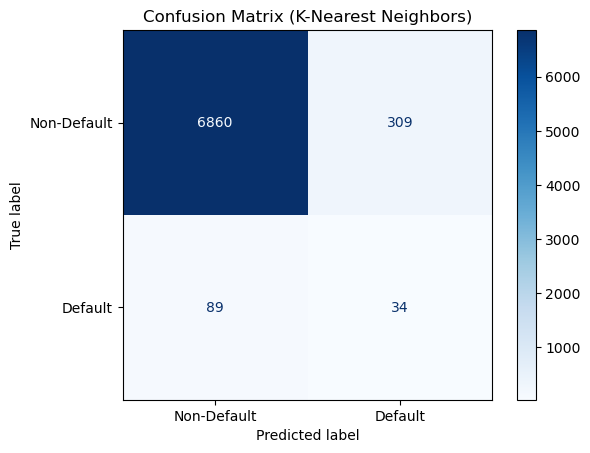

In [62]:
y_pred_knn = knn_model.predict(X_test_processed)

print("\n--- Classification Report (K-Nearest Neighbors) ---")
print(classification_report(
    y_test,
    y_pred_knn,
    target_names=["Class 0 (Non-Default)", "Class 1 (Default)"]
))

cm_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix (K-Nearest Neighbors):")
print(cm_knn)

disp_knn = ConfusionMatrixDisplay(
    confusion_matrix=cm_knn,
    display_labels=["Non-Default", "Default"]
)
disp_knn.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (K-Nearest Neighbors)")
plt.show()

The K-Nearest Neighbors classifier trained after SMOTE yields strong results for the majority “Non-Default” class (precision 0.99, recall 0.96, F1-score 0.97) and achieves a test accuracy of 0.95, but itsn't really what we care about. It still struggles to correctly identify the minority “Default” class—only 28% recall and 0.15 F1-score, with many defaults mislabeled as non-defaults, demonstrating that KNN is worse than our previous random forest found from the grid search
(since the knn is very long to load we will not try to do a grid search or bagging on it as it would take too much time and isn't very efficient anyway)

Now let's try the SVM model as well, first with only a set of parameters to see how it performs.


--- Classification Report (SVM) ---
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.99      0.92      0.95      7169
    Class 1 (Default)       0.08      0.39      0.13       123

             accuracy                           0.91      7292
            macro avg       0.53      0.66      0.54      7292
         weighted avg       0.97      0.91      0.94      7292

Confusion Matrix (SVM):
[[6603  566]
 [  75   48]]


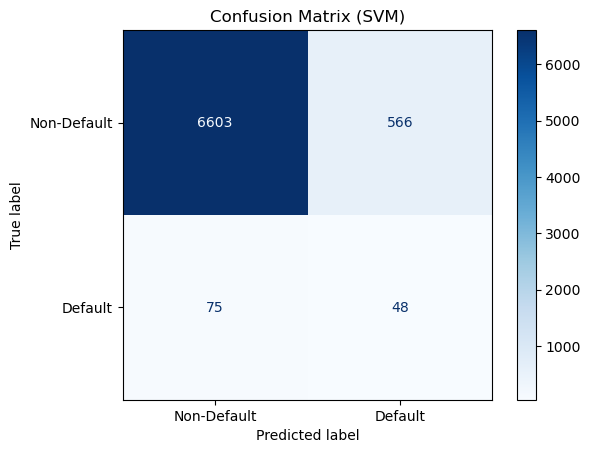

In [64]:

svm_model = SVC(
    kernel='rbf',           
    class_weight='balanced',# useful for imbalanced classes
    C=1.0,                  # regularization parameter
    gamma='scale',          
    random_state=42
)

svm_model.fit(X_train_smote, y_train_smote)   

# Evaluate the model on the test set
y_pred_svm = svm_model.predict(X_test_processed)

print("\n--- Classification Report (SVM) ---")
print(classification_report(
    y_test,
    y_pred_svm,
    target_names=["Class 0 (Non-Default)", "Class 1 (Default)"]
))

cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix (SVM):")
print(cm_svm)

# Plot the confusion matrix
disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=["Non-Default", "Default"]
)
disp_svm.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (SVM)")
plt.show()

The SVM classifier achieves high precision and recall for the majority “Non-Default” class (precision 0.99, recall 0.92, F1-score 0.95) and an overall accuracy of 0.91, but it struggles to detect the minority “Default” class—yielding only 39% recall and 0.13 F1-score, with more than half of defaults misclassified and a notable number of non-defaults incorrectly labeled as defaults. Still SVM is currently the model that found the most true default with 48 against 45 for random forest.

Let's look at the ROC curve for this model

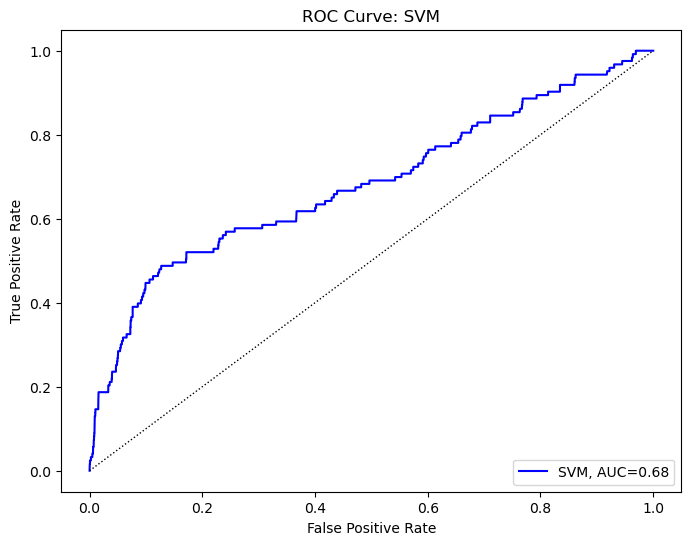

In [71]:

svm_model.fit(X_train_smote, y_train_smote) 
y_scores = svm_model.decision_function(X_test_processed)

# Compute ROC curve and AUC
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_scores)
auc_orig = roc_auc_score(y_test, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_orig, tpr_orig, label=f"SVM, AUC={auc_orig:.2f}", color='blue')
plt.plot([0, 1], [0, 1], 'k:', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SVM')
plt.legend(loc='lower right')
plt.show()

This ROC curve for the SVM trained with SMOTE shows an AUC (Area Under the Curve) of approximately 0.68, which indicates a modest ability to discriminate between the “Default” and “Non-Default” classes. The curve rises above the diagonal random chance line, confirming that the model performs better than guessing but is still far from perfect. The relatively low AUC suggests that while synthetic oversampling via SMOTE helps the SVM improve detection of the minority class, the classifier still struggles to balance true positive rates with false positive rates effectively. This performance level reflects moderate predictive power and indicates room for improvement, possibly via further tuning, advanced ensemble methods, or feature engineering.

Now let's try the SVM model with the same parameters but without smote.


--- Classification Report (SVM without SMOTE) ---
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.99      0.85      0.92      7169
    Class 1 (Default)       0.05      0.49      0.10       123

             accuracy                           0.85      7292
            macro avg       0.52      0.67      0.51      7292
         weighted avg       0.97      0.85      0.90      7292

Confusion Matrix (SVM without SMOTE):
[[6115 1054]
 [  63   60]]


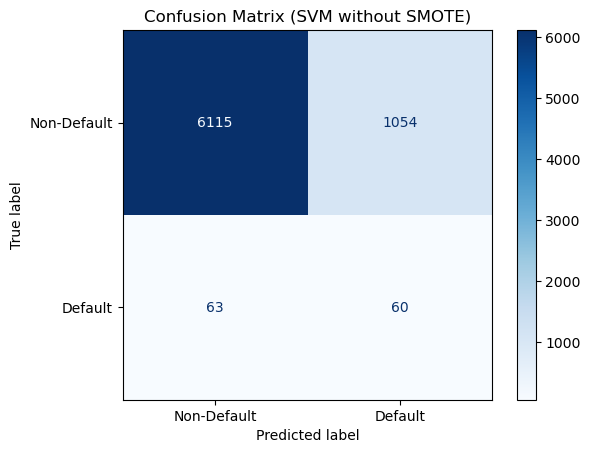

In [95]:
svm_model.fit(X_train_processed, y_train)   

# Evaluate the model on the test set
y_pred_svm2 = svm_model.predict(X_test_processed)

print("\n--- Classification Report (SVM without SMOTE) ---")
print(classification_report(
    y_test,
    y_pred_svm2,
    target_names=["Class 0 (Non-Default)", "Class 1 (Default)"]
))

cm_svm = confusion_matrix(y_test, y_pred_svm2)
print("Confusion Matrix (SVM without SMOTE):")
print(cm_svm)

# Plot the confusion matrix
disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=["Non-Default", "Default"]
)
disp_svm.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (SVM without SMOTE)")
plt.show()

Without SMOTE, the SVM classifier maintains high precision for the “Non-Default” class but drops in recall (0.85 vs 0.92 with SMOTE), and its overall accuracy declines to 0.85; for the minority “Default” class, recall improves slightly (0.49 vs 0.39), and the number of defaults found nearly matches those missed, but the precision and F1-score remain very low (precision 0.05, F1-score 0.10), showing much more confusion between classes,over 1000 non-defaults are mislabeled as defaults,so SMOTE actually boosted class separation for non-defaults but did not solve poor minority class precision, as both approaches struggle with imbalanced boundaries and false positives.

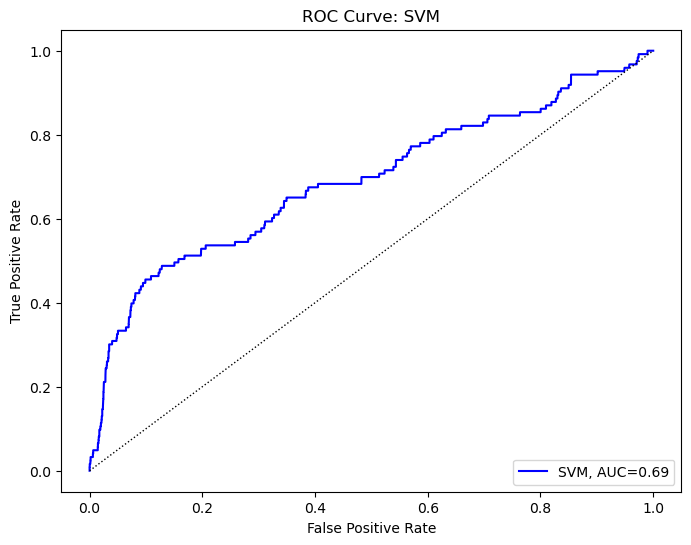

In [77]:
svm_model.fit(X_train_processed, y_train) 
y_scores = svm_model.decision_function(X_test_processed)

# Compute ROC curve and AUC
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_scores)
auc_orig = roc_auc_score(y_test, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_orig, tpr_orig, label=f"SVM, AUC={auc_orig:.2f}", color='blue')
plt.plot([0, 1], [0, 1], 'k:', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SVM')
plt.legend(loc='lower right')
plt.show()

This ROC curve for the SVM trained without SMOTE shows an AUC of 0.69, indicating moderate discriminative power—slightly better than random guessing but not strong. The curve is above the diagonal reference line, so the SVM can distinguish between defaults and non-defaults to a certain extent. However, the AUC is still below 0.7, revealing that the classifier struggles with the imbalanced data, failing to achieve high sensitivity and specificity simultaneously. Overall, while SVM without SMOTE does provide some separation, it does not significantly outperform the SVM with SMOTE (which had an AUC of 0.68); both approaches are limited by the complexity of the class boundary and the severe class imbalance.

Now let's try the LDA algorithm


--- Classification Report (LDA) ---
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.99      0.58      0.73      7169
    Class 1 (Default)       0.02      0.51      0.04       123

             accuracy                           0.58      7292
            macro avg       0.50      0.55      0.38      7292
         weighted avg       0.97      0.58      0.72      7292

Confusion Matrix (LDA):
[[4153 3016]
 [  60   63]]


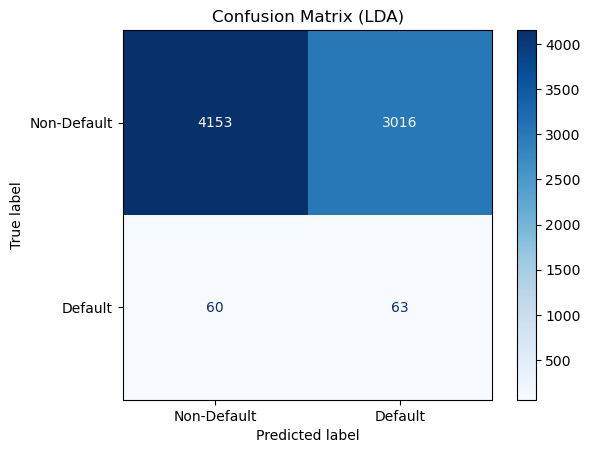

In [89]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_smote.toarray(), y_train_smote)   

# Predict test labels
y_pred_lda = lda_model.predict(X_test_processed)

print("\n--- Classification Report (LDA) ---")
print(classification_report(
    y_test,
    y_pred_lda,
    target_names=["Class 0 (Non-Default)", "Class 1 (Default)"]
))

cm_lda = confusion_matrix(y_test, y_pred_lda)
print("Confusion Matrix (LDA):")
print(cm_lda)

# Plot the confusion matrix
disp_lda = ConfusionMatrixDisplay(
    confusion_matrix=cm_lda,
    display_labels=["Non-Default", "Default"]
)
disp_lda.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (LDA)")
plt.show()

The LDA classifier achieves extremely high precision for “Non-Default” predictions (0.99), but at the expense of recall (0.58), resulting in a large number of non-defaults misclassified as defaults; for the minority “Default” class, recall is moderate (0.51), but precision and F1-score are extremely low (0.02 and 0.04), meaning LDA predicts too many false defaults and has little discriminative power for the positive class. The overall accuracy drops significantly to 0.58, and the confusion matrix shows substantial confusion between the two classes, with nearly half of the true non-defaults predicted as defaults and only half of defaults successfully identified. This model isn't good as it has a too bad recall for the 0s even tho it was the model that found the most True default yet

Now let's try without the smote to compare


--- Classification Report (LDA without SMOTE) ---
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.98      1.00      0.99      7169
    Class 1 (Default)       0.86      0.05      0.09       123

             accuracy                           0.98      7292
            macro avg       0.92      0.52      0.54      7292
         weighted avg       0.98      0.98      0.98      7292

Confusion Matrix (LDA without SMOTE):
[[7168    1]
 [ 117    6]]


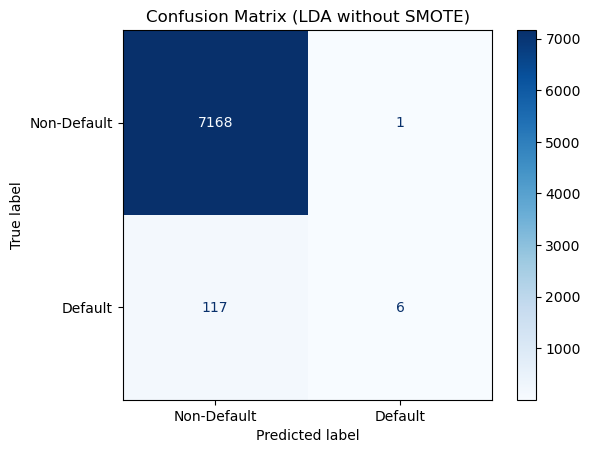

In [91]:
lda_model2 = LinearDiscriminantAnalysis()
lda_model2.fit(X_train_processed.toarray(), y_train)   

y_pred_lda = lda_model2.predict(X_test_processed)

print("\n--- Classification Report (LDA without SMOTE) ---")
print(classification_report(
    y_test,
    y_pred_lda,
    target_names=["Class 0 (Non-Default)", "Class 1 (Default)"]
))

cm_lda = confusion_matrix(y_test, y_pred_lda)
print("Confusion Matrix (LDA without SMOTE):")
print(cm_lda)

# Plot the confusion matrix
disp_lda = ConfusionMatrixDisplay(
    confusion_matrix=cm_lda,
    display_labels=["Non-Default", "Default"]
)
disp_lda.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (LDA without SMOTE)")
plt.show()

Without SMOTE, the LDA model just see almost no Default with only 7 default predicted 6 of 7 where good, but he missed too many to be consider relevant

Now let's test some new models, first the xgboost, we are going to try him with the smote, without the SMOTE, then a grid search parameters on the best of the 2 results (smote or weight)

# 5. Testing more complex models 


--- Classification Report (XGBoost with SMOTE) ---
                   precision    recall  f1-score   support

          Class 0       0.99      0.99      0.99      7169
Class 1 (Default)       0.20      0.21      0.20       123

         accuracy                           0.97      7292
        macro avg       0.59      0.60      0.59      7292
     weighted avg       0.97      0.97      0.97      7292

Confusion Matrix (XGBoost with SMOTE):
[[7062  107]
 [  97   26]]


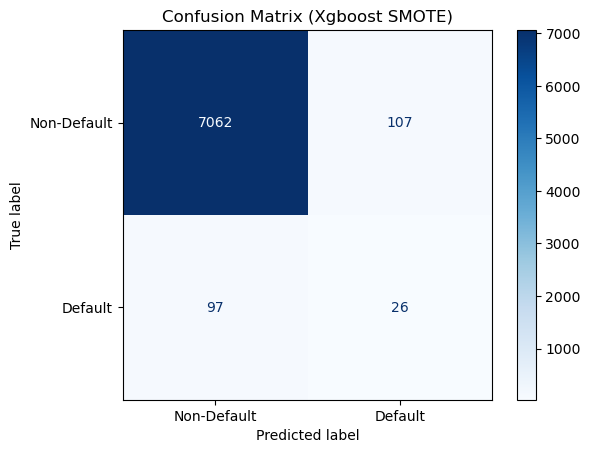

In [67]:

xgb_model = XGBClassifier(random_state=42, 
                          n_estimators=100,
                          n_jobs=-1,
                          eval_metric='logloss') # just to suppress the warnings

xgb_model.fit(X_train_smote, y_train_smote)

# Evaluation
y_pred_xgb = xgb_model.predict(X_test_processed)

print("\n--- Classification Report (XGBoost with SMOTE) ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Class 0', 'Class 1 (Default)']))

cm_xgb1 = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix (XGBoost with SMOTE):")
print(cm_xgb1)

disp_xgb1 = ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb1,
    display_labels=["Non-Default", "Default"]
)
disp_xgb1.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Xgboost SMOTE)")
plt.show()

The XGBoost model trained with SMOTE shows strong performance in identifying the majority class, correctly classifying 7,062 "Non-Default" instances while mislabeling 107 as "Default". However, despite SMOTE balancing, the model struggles significantly with the minority class, correctly detecting only 26 actual defaults while missing 97 cases, indicating that the synthetic oversampling was insufficient to overcome the severe class imbalance for effective default detection.

Calculation of 'scale_pos_weight': 58.16 (which is, 28672 / 493)

--- Classification Report (XGBoost without SMOTE) ---
                   precision    recall  f1-score   support

          Class 0       0.99      0.96      0.97      7169
Class 1 (Default)       0.15      0.46      0.23       123

         accuracy                           0.95      7292
        macro avg       0.57      0.71      0.60      7292
     weighted avg       0.98      0.95      0.96      7292

Confusion Matrix (XGBoost without SMOTE):
[[6851  318]
 [  67   56]]


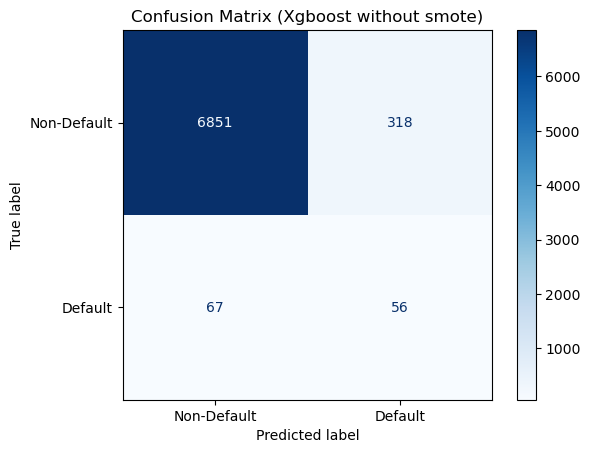

In [71]:
# Calculation of the weight for the scale
counts = Counter(y_train)
scale_pos_weight = counts[0] / counts[1]
print(f"Calculation of 'scale_pos_weight': {scale_pos_weight:.2f} (which is, {counts[0]} / {counts[1]})")

xgb_model = XGBClassifier(random_state=42, 
                          n_estimators=100,
                          scale_pos_weight=scale_pos_weight, # we use this to give more importance to the class 1
                          n_jobs=-1,
                          eval_metric='logloss') # To suppress a warning
#this time we use basic processed data set and not the smote one
xgb_model.fit(X_train_processed, y_train)

# Evaluation
y_pred_xgb = xgb_model.predict(X_test_processed)

print("\n--- Classification Report (XGBoost without SMOTE) ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Class 0', 'Class 1 (Default)']))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix (XGBoost without SMOTE):")
print(cm_xgb)

disp_xgb = ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb,
    display_labels=["Non-Default", "Default"]
)
disp_xgb.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Xgboost without smote)")
plt.show()

Without SMOTE, the XGBoost model shows a marked improvement in detecting the minority class, correctly identifying 56 default cases (more than double the 26 found with SMOTE). While this increased sensitivity comes with a slight trade-off—identifying fewer non-defaults correctly (6,851 vs 7,062) and generating more false positives (318 vs 107),the significantly better recall for actual defaults makes this model far more useful for risk detection purposes than the SMOTE-balanced version.

Usage of the scale weight 58.16
Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}

Evaluation of the best estimator found : 

 Classification report (best XGBoost)
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.99      0.97      0.98      7169
    Class 1 (Default)       0.20      0.46      0.28       123

             accuracy                           0.96      7292
            macro avg       0.60      0.71      0.63      7292
         weighted avg       0.98      0.96      0.97      7292

Confusion Matrix (best XGBoost):
[[6951  218]
 [  67   56]]


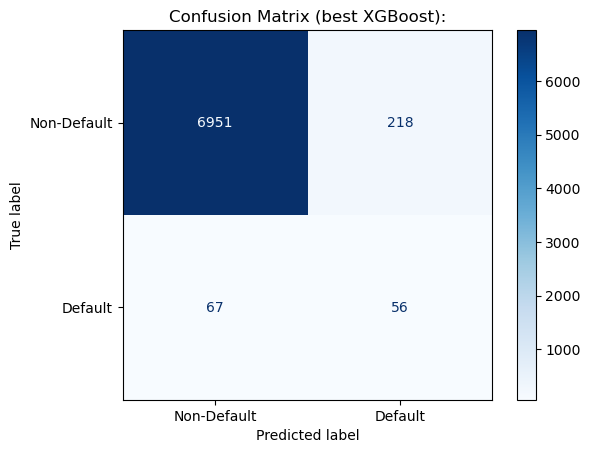

In [85]:
counts = Counter(y_train)
scale_pos_weight = counts[0] / counts[1]
print(f"Usage of the scale weight {scale_pos_weight:.2f}")


# test grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],         
    'max_depth': [5, 10],             
    'learning_rate': [0.05, 0.1]     
}

# GridSearchCV
# we create a base XGBoost model
xgb_base = XGBClassifier(random_state=42, 
                         scale_pos_weight=scale_pos_weight, # On le fixe !
                         n_jobs=-1,
                         eval_metric='logloss')
#then the grid with different parameters
grid_search_xgb = GridSearchCV(estimator=xgb_base, 
                               param_grid=param_grid_xgb, 
                               cv=3, 
                               scoring='f1', 
                               n_jobs=-1,
                               verbose=2)

grid_search_xgb.fit(X_train_processed, y_train)

print(grid_search_xgb.best_params_)

print("\nEvaluation of the best estimator found : ")

best_xgb_model = grid_search_xgb.best_estimator_

y_pred_best_xgb = best_xgb_model.predict(X_test_processed)

print("\n Classification report (best XGBoost)")
print(classification_report(y_test, y_pred_best_xgb, target_names=['Class 0 (Non-Default)', 'Class 1 (Default)']))

cm_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)
print("Confusion Matrix (best XGBoost):")
print(cm_best_xgb)

# display
disp_best_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_best_xgb, display_labels=['Non-Default', 'Default'])
disp_best_xgb.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (best XGBoost):")
plt.show()

We obtain a better result with the grid search, we go from 318 to only 218 default while it was non-Defaults it is for now our best model but we still have to try cat boost and then the voting of the several algorithms 

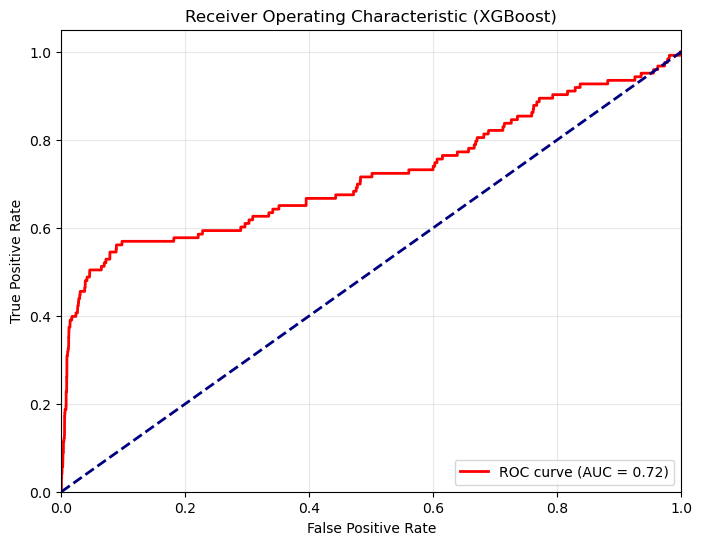

In [31]:
y_probs_xgb = best_xgb_model.predict_proba(X_test_processed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb)

# 3. Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# 4. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guessing)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (XGBoost)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

This ROC curve evaluates the XGBoost model's ability to distinguish between the two classes, achieving an AUC of 0.72. The red line rises very rapidly at the beginning, which is a good sign, it means the model can correctly identify about 40-50% of the positive cases with very few false positives. However, as the curve progresses, it flattens out and stays closer to the random guessing line, indicating that after catching the "easy" cases, the model struggles to find the remaining positive cases without making mistakes. An AUC of 0.72 is considered acceptable, meaning the model has some predictive power but is far from perfect. In our case, it is quite acceptable for a credit fraud prediction.

This one gave the best results, in terms of recall for the 1 with 63 default found but he got more default while it's non default


--- Classification Report (CAT without SMOTE) ---
                   precision    recall  f1-score   support

          Class 0       0.99      0.95      0.97      7169
Class 1 (Default)       0.14      0.51      0.23       123

         accuracy                           0.94      7292
        macro avg       0.57      0.73      0.60      7292
     weighted avg       0.98      0.94      0.96      7292

Confusion Matrix (CAT without SMOTE):
[[6796  373]
 [  60   63]]


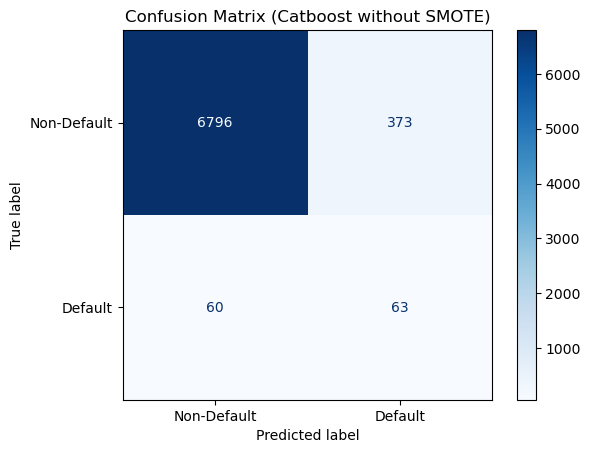

In [73]:
#CatBoost 
counts = Counter(y_train)
scale_pos_weight = counts[0] / counts[1]
clf_cat = CatBoostClassifier(random_state=42,
                             n_estimators=200, 
                             scale_pos_weight=scale_pos_weight, # We use the same weight
                             verbose=0) # to keep it silent

clf_cat.fit(X_train_processed, y_train)

# Evaluation
y_pred_cat = clf_cat.predict(X_test_processed)

print("\n--- Classification Report (CAT without SMOTE) ---")
print(classification_report(y_test, y_pred_cat, target_names=['Class 0', 'Class 1 (Default)']))

cm_cat = confusion_matrix(y_test, y_pred_cat)
print("Confusion Matrix (CAT without SMOTE):")
print(cm_cat)

disp_cat = ConfusionMatrixDisplay(
    confusion_matrix=cm_cat,
    display_labels=["Non-Default", "Default"]
)
disp_cat.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Catboost without SMOTE)")
plt.show()

The CatBoost model, trained without SMOTE, demonstrates a strong ability to detect minority cases compared to other methods, correctly identifying 63 defaults (True Positives) with a recall of 0.51 for the positive class. While this increased sensitivity leads to a higher number of False Positives (373) compared to XGBoost, this model has the highest number of detected defaults among the models tested so far, making it a potentially superior choice if the priority is maximizing fraud/default detection even at the cost of some precision.


--- Top 10 Features (Catboost Model) ---
                                              Feature  Importance
4                                      num__AGE_YEARS   20.943316
5                                 num__YEARS_EMPLOYED   17.703582
0                               num__AMT_INCOME_TOTAL   15.200166
8                                 cat__FLAG_OWN_CAR_N    2.137803
2                                     num__FLAG_PHONE    2.127051
16                      cat__NAME_INCOME_TYPE_Working    1.872008
19  cat__NAME_EDUCATION_TYPE_Secondary / secondary...    1.834820
11                             cat__FLAG_OWN_REALTY_Y    1.770598
38                      cat__OCCUPATION_TYPE_Laborers    1.759962
1                                num__FLAG_WORK_PHONE    1.664426

Creating the plot...


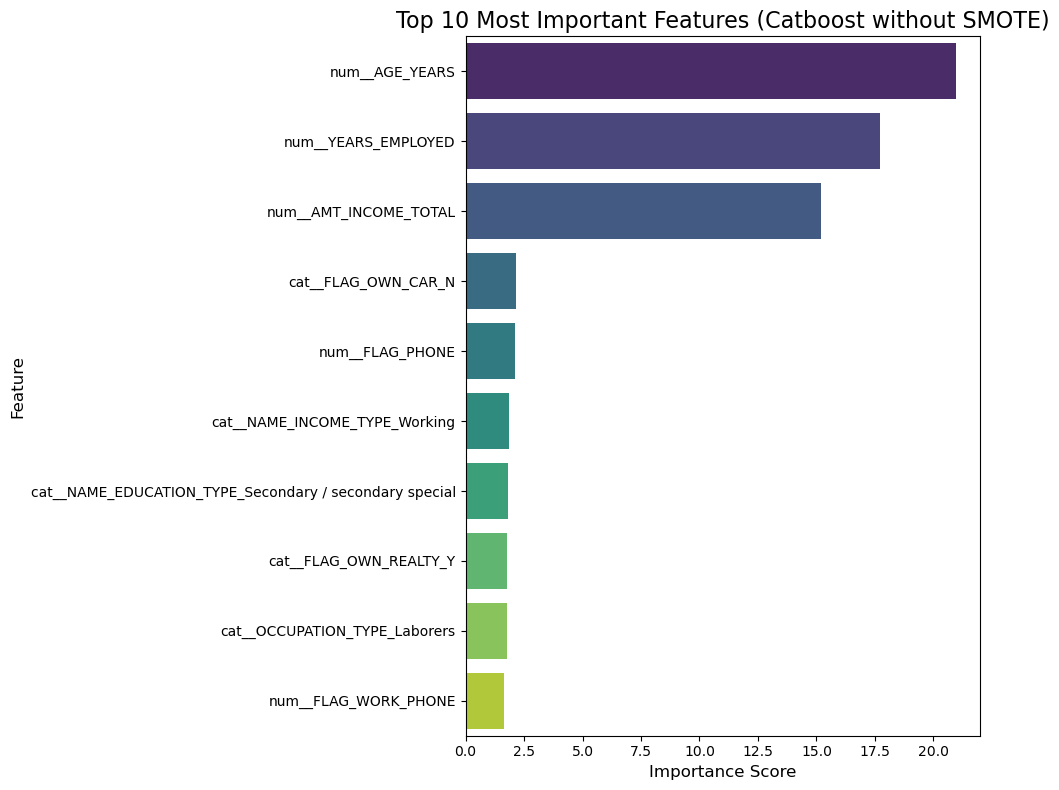

In [97]:
# get the column names
feature_names = preprocessor.get_feature_names_out()

# get the feature importance scores from the cat model which is our best model for the default found
importances = clf_cat.feature_importances_

# Create a DataFrame for the manipulation
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Take the Top 10
top_10_features = importance_df.head(10)

print("\n--- Top 10 Features (Catboost Model) ---")
print(top_10_features)

print("\nCreating the plot...")
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Most Important Features (Catboost without SMOTE)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

The feature importance analysis for the CatBoost model reveals that three key numerical features dominate the prediction process: AGE_YEARS, YEARS_EMPLOYED, and AMT_INCOME_TOTAL. Together, these demographic and financial indicators have more than the half of the model's decision-making power. The remaining top features include categorical variables related to asset ownership (car, realty), employment type, and education, but their individual contributions are significantly smaller, highlighting that personal stability and financial history are the primary drivers of default risk in this model.

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found: {'depth': 10, 'learning_rate': 0.1, 'n_estimators': 200, 'scale_pos_weight': 58.16}

--- Classification Report (Best CatBoost) ---
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.99      0.97      0.98      7169
    Class 1 (Default)       0.18      0.44      0.25       123

             accuracy                           0.96      7292
            macro avg       0.58      0.70      0.62      7292
         weighted avg       0.98      0.96      0.97      7292

Confusion Matrix (Best CatBoost):
[[6919  250]
 [  69   54]]


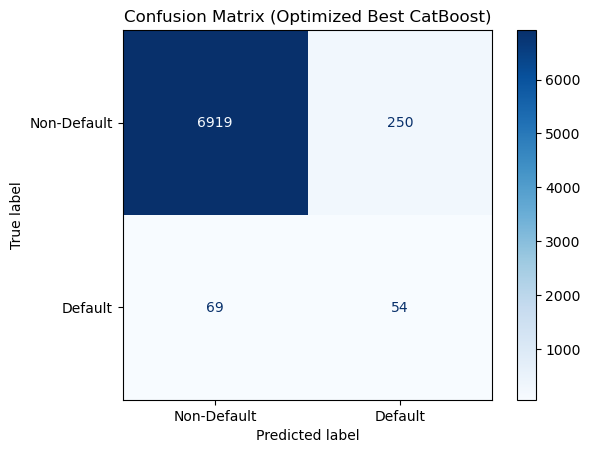

In [75]:
# Grid search for CatBoost (8 combinations)
param_grid_cat = {
    'n_estimators': [100, 200],         # Alias for 'iterations'
    'learning_rate': [0.05, 0.1],       # Learning rate
    'depth': [5, 10],                   # Tree depth (alias for 'max_depth')
    
    # Fix the most important parameter (no search)
    'scale_pos_weight': [58.16]         
}
cat_base = CatBoostClassifier(random_state=42, scale_pos_weight=scale_pos_weight, verbose=0)

#Configure GridSearch for f1
grid_search_cat = GridSearchCV(estimator=cat_base, 
                               param_grid=param_grid_cat, 
                               cv=3, 
                               scoring='f1', # optimize for recall without leaving aside the precision
                               n_jobs=-1,
                               verbose=2)

grid_search_cat.fit(X_train_processed, y_train)

print(f"Best parameters found: {grid_search_cat.best_params_}")

best_cat_model = grid_search_cat.best_estimator_

y_pred_best_cat = best_cat_model.predict(X_test_processed)

print("\n--- Classification Report (Best CatBoost) ---")
print(classification_report(y_test, y_pred_best_cat, target_names=['Class 0 (Non-Default)', 'Class 1 (Default)']))

cm_best_cat = confusion_matrix(y_test, y_pred_best_cat)
print("Confusion Matrix (Best CatBoost):")
print(cm_best_cat)

# Graphical display
disp_best_cat = ConfusionMatrixDisplay(confusion_matrix=cm_best_cat, display_labels=['Non-Default', 'Default'])
disp_best_cat.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Optimized Best CatBoost)")
plt.show()


Actually since we focused on f1 score the default recall was worse than our first try on cat boost, and it is also worst than best xgboost has it had more default found and less mistake for non default guessed as default. So overall this new model isn't relevent for us

# Voting implementation

Voting for the Team without smote (best random forest, best cat, best xgboost, with a soft vote so we take into account the probabilities)


Creating the Voting Classifier
Training the ensemble model
Training complete

Classification Report
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.99      0.97      0.98      7169
    Class 1 (Default)       0.20      0.45      0.27       123

             accuracy                           0.96      7292
            macro avg       0.59      0.71      0.63      7292
         weighted avg       0.98      0.96      0.97      7292

Confusion Matrix:
[[6947  222]
 [  68   55]]


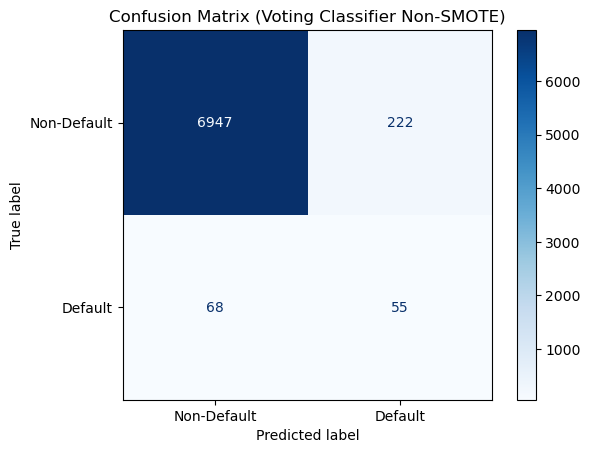

In [351]:
# The best random forest
clf_rf_best = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# The best Xgboost
clf_xgb_best = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

# The best CatBoost
clf_cat_best = CatBoostClassifier(
    n_estimators=200,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=0 
)

# Grouping the 3 models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', clf_rf_best), 
        ('xgb', clf_xgb_best), 
        ('cat', clf_cat_best)
    ],
    voting='soft', # Vote by probabilities, so like it takes the average of the 3 models to decide it's choice
    n_jobs=1
)

voting_clf.fit(X_train_processed, y_train)

# Evaluation on the test set
y_pred_voting = voting_clf.predict(X_test_processed)

print("\nClassification Report")
print(classification_report(y_test, y_pred_voting, target_names=['Class 0 (Non-Default)', 'Class 1 (Default)']))

cm_voting = confusion_matrix(y_test, y_pred_voting)
print("Confusion Matrix:")
print(cm_voting)

disp_voting = ConfusionMatrixDisplay(confusion_matrix=cm_voting, display_labels=['Non-Default', 'Default'])
disp_voting.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Voting Classifier Non-SMOTE)")
plt.show()

The Voting Classifier (combining Random Forest, CatBoost, and XGBoost without SMOTE) achieves a balanced performance with 55 defaults correctly identified (recall 0.45), comparable to the standalone XGBoost model but slightly less sensitive than CatBoost alone. It maintains high overall accuracy (0.96) and precision for non-defaults (0.99), with fewer false positives (222) than CatBoost, suggesting that the ensemble approach successfully moderates the aggressive prediction of the individual models to provide a stable, albeit slightly less sensitive, default detection mechanism.

Test that consider 1 each time a model says it is 1 even if the 2 others disagree. We do this to see if we can increase the number of 1 found (so the recall of the 1s)

Individual predictions retrieved
Voting combination (Zero Tolerance strategy)
Evaluation of the Zero Tolerance Vote

Classification Report
                       precision    recall  f1-score   support

Class 0 (Non-Default)       0.99      0.94      0.97      7169
    Class 1 (Default)       0.13      0.51      0.21       123

             accuracy                           0.93      7292
            macro avg       0.56      0.73      0.59      7292
         weighted avg       0.98      0.93      0.95      7292

Confusion Matrix:
[[6755  414]
 [  60   63]]


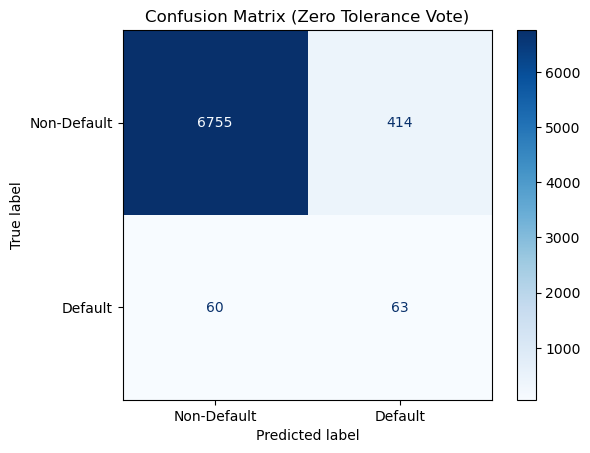

In [355]:
clf_rf_best.fit(X_train_processed, y_train)
clf_xgb_best.fit(X_train_processed, y_train)
clf_cat_best.fit(X_train_processed, y_train)

y_pred_rf = clf_rf_best.predict(X_test_processed)
y_pred_xgb = clf_xgb_best.predict(X_test_processed)
y_pred_cat = clf_cat_best.predict(X_test_processed)



#Voting combination Zero Tolerance strategy
# Create a DataFrame with the 3 votes
votes_df = pd.DataFrame({
    'RF': y_pred_rf,
    'XGB': y_pred_xgb,
    'CAT': y_pred_cat
})

#Here we do this to take a 1 if one of the 3 models predicted a 1, so basically it is like a OR.
y_pred_tolerance_zero = votes_df.max(axis=1)


print("\nClassification Report")
print(classification_report(y_test, y_pred_tolerance_zero, target_names=['Class 0 (Non-Default)', 'Class 1 (Default)']))

cm_voting = confusion_matrix(y_test, y_pred_tolerance_zero)
print("Confusion Matrix:")
print(cm_voting)

# Display
disp_voting = ConfusionMatrixDisplay(confusion_matrix=cm_voting, display_labels=['Non-Default', 'Default'])
disp_voting.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Zero Tolerance Vote)")
plt.show()

We see with a bit of surprise that we got the same amount of Default found here than with the Best Cat model so we can conclude that all the default found by the others models are also found by cat

**Correlation matrix**
We are now going to do a correlation matrix to see if some columns are too correlated between each other maybe we should remove them to make our models work better


Correlation with the target (STATUS_BINARY):
STATUS_BINARY       1.000000
FLAG_WORK_PHONE     0.005640
IS_UNEMPLOYED       0.005313
FLAG_PHONE          0.001585
CNT_CHILDREN       -0.000308
AMT_INCOME_TOTAL   -0.001057
AGE_YEARS          -0.001478
FLAG_EMAIL         -0.002434
CNT_FAM_MEMBERS    -0.005660
YEARS_EMPLOYED     -0.022669
Name: STATUS_BINARY, dtype: float64

Displaying the Correlation Heatmap...


Text(0.5, 1.0, 'Correlation Matrix of Numeric Features')

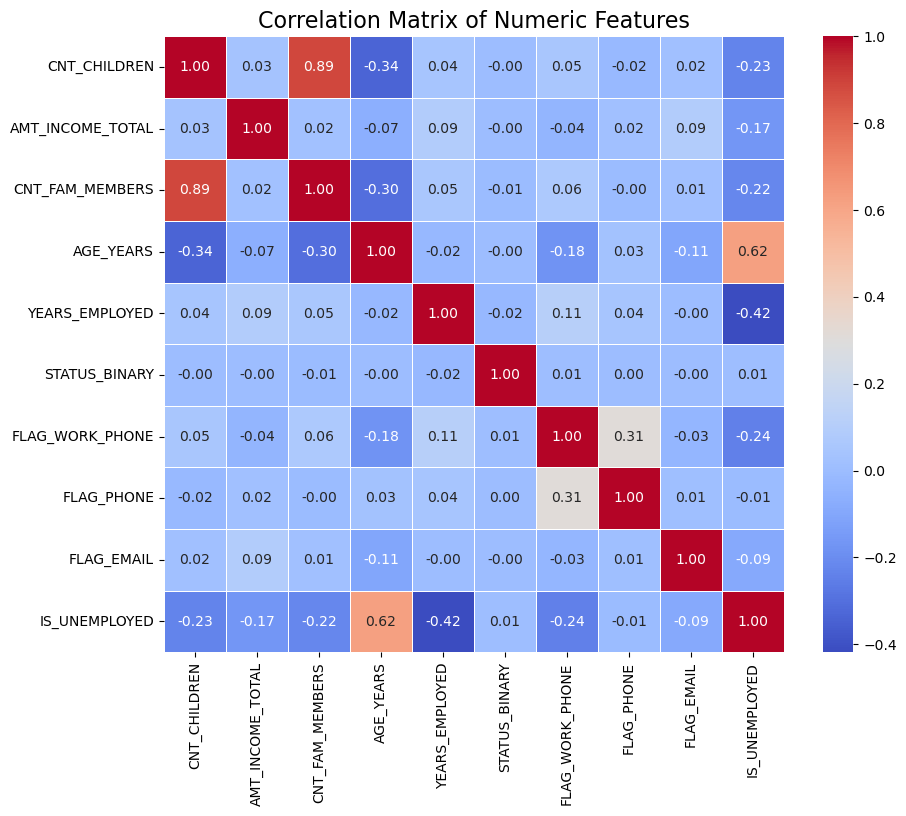

In [379]:
numerical_features = [
    'CNT_CHILDREN', 
    'AMT_INCOME_TOTAL', 
    'CNT_FAM_MEMBERS',
    'AGE_YEARS',         
    'YEARS_EMPLOYED',    
    'STATUS_BINARY', # Our target
    'FLAG_WORK_PHONE',
    'FLAG_PHONE',
    'FLAG_EMAIL',
    'IS_UNEMPLOYED'      
]

# Create a new data set with these columns
df_numeric = df[numerical_features]

# We do the correlation matrix 
corr_matrix = df_numeric.corr()

# Display the correlation with the Status binary, our target
print("\nCorrelation with the target (STATUS_BINARY):")
print(corr_matrix['STATUS_BINARY'].sort_values(ascending=False))

# Display the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,     
            cmap='coolwarm',
            fmt=".2f",    
            linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)


This correlation matrix shows us the connections between the numeric features in the dataset. We can see a very strong link between CNT_CHILDREN and CNT_FAM_MEMBERS (0.89), which is logical because more children means a bigger family. There is also a notable positive link between AGE_YEARS and IS_UNEMPLOYED (0.62), which might mean older people in this dataset are often unemployed, possibly due to retirement. On the other hand, a person with more YEARS_EMPLOYED is less likely to be unemployed, as shown by the negative correlation of -0.42. What is most important for our model is that our target, STATUS_BINARY, has almost no linear connection to any of these numeric features; all its correlation values are very close to zero. This tells us that a simple line cannot separate the good and bad clients, which is why we must use more advanced models like XGBoost and CatBoost to find the hidden patterns

Let's encode try to feature engineer a second time some of the features to combine the rare categories in the same category to make the data simpler. And see if we get better results

In [77]:
df_encod2=df_encod.copy()

df_encod2['NAME_EDUCATION_TYPE'] = df_encod2['NAME_EDUCATION_TYPE'].replace({
    'Office apartment': 'Other_Appartment',
    'Municipal apartment': 'Other_Appartment',
    'With parents': 'Other_Appartment',
    'Co-op apartment' : 'Other_Appartment'
})
  
#top_10_occupations = df_encod2['OCCUPATION_TYPE'].value_counts().nlargest(10).index
#df_encod2['OCCUPATION_TYPE_CAT'] = df_encod2['OCCUPATION_TYPE'].apply(lambda x: x if x in top_10_occupations else 'Other_Occupation')
#df_encod2 = df_encod2.drop(columns=['OCCUPATION_TYPE']) #didn't give a good result

In [79]:
df_drop=df_encod2.copy()

In [81]:
y2=df_drop["STATUS_BINARY"]
X2=df_drop.drop(columns=["STATUS_BINARY","ID"])
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.2,random_state=42,stratify=y)
print(f"Separated data : {X_train2.shape[0]} Train data, {X_test2.shape[0]} Test data")

numerical_cols2 = X2.select_dtypes(include=['int64', 'float64']).columns
categorical_cols2 = X2.select_dtypes(include=['object', 'string']).columns

print(f"Numerical Columns (need Scaling) : {list(numerical_cols2)}")
print(f"Categorical Columns (need encoding) : {list(categorical_cols2)}")

numeric_transformer2 = StandardScaler()
categorical_transformer2 = OneHotEncoder(handle_unknown='ignore')

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer2, numerical_cols2),
        ('cat', categorical_transformer2, categorical_cols2)
    ])
X_train_processed2 = preprocessor2.fit_transform(X_train2)
X_test_processed2 = preprocessor2.transform(X_test2)



Separated data : 29165 Train data, 7292 Test data
Numerical Columns (need Scaling) : ['AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'AGE_YEARS', 'YEARS_EMPLOYED']
Categorical Columns (need encoding) : ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'CNT_CHILDREN_CAT', 'CNT_FAM_MEMBERS_CAT']


In [83]:
counts = Counter(y_train2)
scale_pos_weight = counts[0] / counts[1]

clf_cat2 = CatBoostClassifier(random_state=42,
                             n_estimators=200, # On utilise 200 pour être comparable
                             scale_pos_weight=scale_pos_weight, # On utilise le même poids
                             verbose=0) # 'verbose=0' pour le rendre silencieux

clf_cat2.fit(X_train_processed2, y_train2)

# Évaluation
y_pred_cat2 = clf_cat2.predict(X_test_processed2)

print("\n--- Repport of Classification (CAT without SMOTE) ---")
print(classification_report(y_test2, y_pred_cat2, target_names=['Class 0', 'Class 1 (Default)']))
cm_cat2 = confusion_matrix(y_test2, y_pred_cat2)
print("Confusion matrix (CAT without SMOTE):")
print(cm_cat2)


--- Repport of Classification (CAT without SMOTE) ---
                   precision    recall  f1-score   support

          Class 0       0.99      0.95      0.97      7169
Class 1 (Default)       0.14      0.51      0.23       123

         accuracy                           0.94      7292
        macro avg       0.57      0.73      0.60      7292
     weighted avg       0.98      0.94      0.96      7292

Confusion matrix (CAT without SMOTE):
[[6796  373]
 [  60   63]]


So the new encoding didn't changed the results (Actually tried some others but it only made worst results so we didn't kept them)

Now let's try to maximize our best catboost algorithm and set a threshold for the recall to be maximum.

Treshold found : 0.0106

--- Report classification (with modified treshold) ---
                   precision    recall  f1-score   support

          Class 0       0.99      0.24      0.38      7169
Class 1 (Default)       0.02      0.91      0.04       123

         accuracy                           0.25      7292
        macro avg       0.51      0.57      0.21      7292
     weighted avg       0.98      0.25      0.38      7292

Confusion matrix :
[[1707 5462]
 [  11  112]]


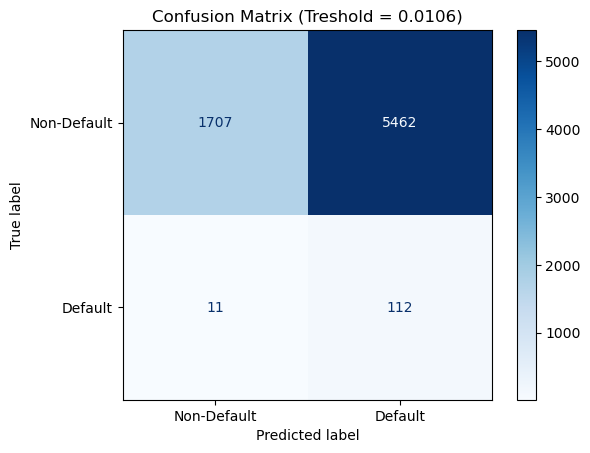

In [105]:
# 2. We take back the best cat boost we had which is our model that found the more 1 for now
counts = Counter(y_train)
scale_pos_weight = counts[0] / counts[1]

clf_cat = CatBoostClassifier(random_state=42,
                             n_estimators=200, 
                             scale_pos_weight=scale_pos_weight, 
                             verbose=0) 

clf_cat.fit(X_train_processed, y_train)

#we take the probabilities
y_proba = clf_cat.predict_proba(X_test_processed)[:, 1] #because we care about 1s recall not 0

#We take the different metrics to evaluate the model
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

#now we are going to test different treshold values to get the most of the 1 possible (we went for 90%)
desired_recall = 0.9

#We search the index for which recall become higher than treshold
idx = np.argmax(recall < desired_recall) 

target_threshold = thresholds[idx-1]

print(f"Treshold found : {target_threshold:.4f}")

#Apply the treshold so that every proba higher than the new treshold are taken as 1 instead of needing a proba higher than 50%
y_pred_max_recall = (y_proba >= target_threshold).astype(int)

print("\n--- Report classification (with modified treshold) ---")
print(classification_report(y_test, y_pred_max_recall, target_names=['Class 0', 'Class 1 (Default)']))

cm_max = confusion_matrix(y_test, y_pred_max_recall)
print("Confusion matrix :")
print(cm_max)

# display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_max, display_labels=['Non-Default', 'Default'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Treshold = {target_threshold:.4f})")
plt.show()

By drastically lowering the decision threshold to ~0.0106 to maximize recall, the CatBoost model successfully identifies nearly all default cases (112 out of 123, recall 0.91), achieving the primary goal of catching fraud. However, this comes at an extreme cost to precision: the model flags over 76% of legitimate customers as defaults (5462 False Positives), resulting in a precision of only 0.02 and an overall accuracy of just 0.25. While finding most of the credit default, there is too many people found as false negative to be able to use this model.

There is a metric called the F score. And usually we talk about F1 score. But actually there are other number like F2 etc. And the more you increase the F value the more it prioritize recall over precision

Best Treshold : 0.5438
Best F -Score : 0.4819
Best Recall : 51.22%
Best precision : 15.40%

Confusion matrix for an F6:
[[6823  346]
 [  60   63]]


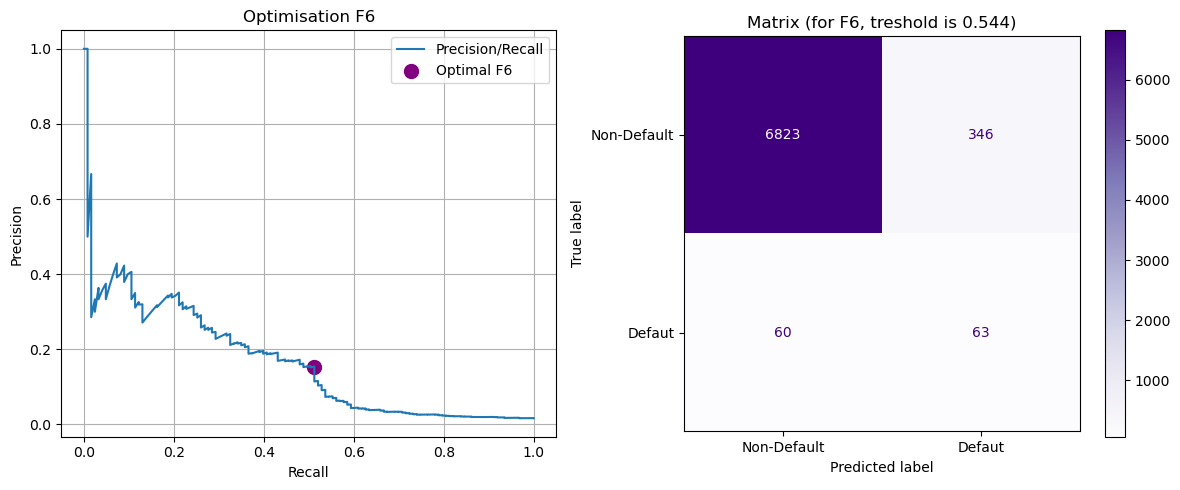

In [91]:
counts = Counter(y_train)
scale_pos_weight = counts[0] / counts[1]

clf_cat = CatBoostClassifier(
    n_estimators=200, 
    scale_pos_weight=scale_pos_weight, 
    random_state=42, 
    verbose=0
)
clf_cat.fit(X_train_processed, y_train)

y_proba = clf_cat.predict_proba(X_test_processed)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

#computing of F - score (here we took took for f6 as it gave a slightly better result than before, but if we increase to an higher beta then
#the same as above will do with changing the treshold
beta = 6
numerator = (1 + beta**2) * precision * recall
denominator = (beta**2 * precision) + recall + 1e-10
f10_scores = numerator / denominator   #it is called f10 score but that is because we tried f10 first but actually it wasn't good so changed to f6

# Finding the best f6 score
ix = np.argmax(f10_scores)
best_thresh = thresholds[ix]
best_f10 = f10_scores[ix]

print(f"Best Treshold : {best_thresh:.4f}")
print(f"Best F -Score : {best_f10:.4f}")
print(f"Best Recall : {recall[ix]:.2%}")
print(f"Best precision : {precision[ix]:.2%}")

#Apply the treshold so that every proba higher than the new treshold are taken as 1 instead of needing a proba higher than 50%
y_pred_f10 = (y_proba >= best_thresh).astype(int)

cm_f10 = confusion_matrix(y_test, y_pred_f10)
print("\nConfusion matrix for an F6:")
print(cm_f10)

# Display
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(recall, precision, label='Precision/Recall')
plt.scatter(recall[ix], precision[ix], marker='o', color='purple', s=100, label=f'Optimal F6')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f"Optimisation F6")
plt.legend()
plt.grid()

# Matrice
plt.subplot(1, 2, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_f10, display_labels=['Non-Default', 'Defaut'])
disp.plot(cmap='Purples', values_format='d', ax=plt.gca())
plt.title(f"Matrix (for F6, treshold is {best_thresh:.3f})")

plt.tight_layout()
plt.show()

In this experiment, we tried to balance our model using the "F6-Score" strategy, which prioritizes finding defaults 6 times more than precision. The result is much more reasonable than before. We successfully identified 63 defaults, which is good, but we also made 346 mistakes , meaning our precision is around 15.40%. This is a compromise: we catch half of the bad clients, but for every 1 real fraud we find, we wrongly suspect about 5 innocent people. It is much better than the previous attempt where we suspected everyone, and this threshold of 0.544 seems to be a "sweet spot" where the model is useful without being too annoying for normal customers.

Isolation Forest is an unsupervised algorithm that detects anomalies by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature

Let's try this unsupervised model on our data


--- Classifiaction report ---
                     precision    recall  f1-score   support

Class 0 non Default       0.98      0.99      0.98      7169
   Classe 1 Default       0.03      0.02      0.03       123

           accuracy                           0.97      7292
          macro avg       0.51      0.51      0.51      7292
       weighted avg       0.97      0.97      0.97      7292

Confusion Matrix :
[[7070   99]
 [ 120    3]]


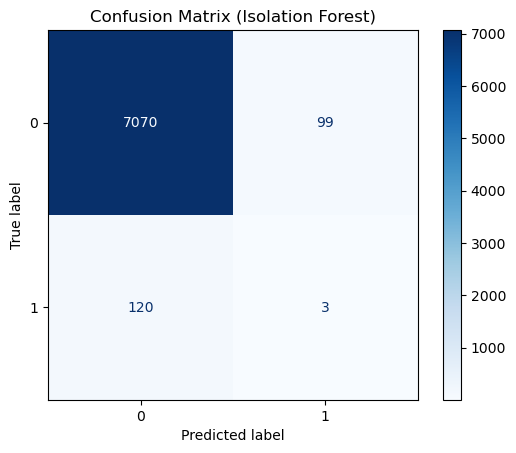

In [95]:
counts = Counter(y_train)
contamination_rate = counts[1] / (counts[0] + counts[1])

# n_estimators=100 : Nombre d'arbres
# contamination : is the % of données the model consider as anomaly, so the minority class
iso_forest = IsolationForest(n_estimators=100, 
                             contamination=contamination_rate, 
                             random_state=42, 
                             n_jobs=-1)

iso_forest.fit(X_train_processed)


#isolation tree give back 1 and - 1 (for inliners and outliers respectively)
y_pred_iso_raw = iso_forest.predict(X_test_processed)

#so here we just change the -1 in 1 and 1 in 0
y_pred_iso = np.where(y_pred_iso_raw == -1, 1, 0) #this is  a if else

print("\n--- Classifiaction report ---")
print(classification_report(y_test, y_pred_iso, target_names=['Class 0 non Default', 'Classe 1 Default']))

cm_iso = confusion_matrix(y_test, y_pred_iso)
print("Confusion Matrix :")
print(cm_iso)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_iso, display_labels=['0', '1'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Isolation Forest)")
plt.show()

The poor performance of the Isolation Forest is a significant information. It indicates that the fraud cases in our dataset are not geometric outliers.

Unlike typical anomalies (for exemple a credit card transaction of $1M made in Antarctica), our defaulters look statistically very similar to normal clients (same age range, same income distribution).

They are "hidden" within the main cluster of data, making them invisible to density-based or distance-based anomaly detection methods.

This confirms that we need supervised learning like xbgoost and catboost, and that unsupervised will not work

Let's now use the embedded method : LASSO to do a feature selection to see if we can get a better performance for xgboost.

Original features: 60
Features kept by Lasso: 14
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7169
           1       0.35      0.07      0.11       123

    accuracy                           0.98      7292
   macro avg       0.67      0.53      0.55      7292
weighted avg       0.97      0.98      0.98      7292

Confusion Matrix:
[[7154   15]
 [ 115    8]]


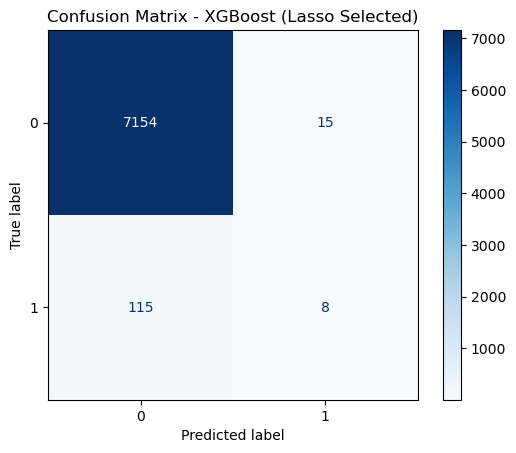

In [93]:
# Use Logistic Regression with L1 penalty (Lasso) for selection
# The 'C' parameter controls selection strength (smaller C = fewer features selected)
# solver='liblinear' or 'saga' is required for L1 penalty
lasso_selector = SelectFromModel(
    LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
)

# Fit the selector and transform the data
lasso_selector.fit(X_train_processed, y_train)
X_train_selected = lasso_selector.transform(X_train_processed)
X_test_selected = lasso_selector.transform(X_test_processed)

print(f"Original features: {X_train_processed.shape[1]}")
print(f"Features kept by Lasso: {X_train_selected.shape[1]}")

# Train XGBoost on the selected features
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train_selected, y_train)

# Evaluation
y_pred = xgb.predict(X_test_selected)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix - XGBoost (Lasso Selected)")
plt.show()

Using Lasso as a strict filter before XGBoost has hurt our model's ability to detect the minority class since it struggles even more to detect the minority class, with only 7 good defaults predicted.

## Conclusion

To briefly conclude this Notebook (more details in the word repport).
Our best models we could find where an xgboost and a catboost. They managed to have over 50% recall, with about 25% precision. Which is a good result considering we only have at the being 1.69% defaulter. Since we missed about 60 defaulter, it means there are 60 people that will go undected in the 7000 that we will agree to give a loan. So less than 1%. To compensate this risk we can increase the loan interest by 1% (so for exemple instead of being 2% it would be 2.02%), which should counterbalance. And for the 300 people predicted as fraud the bank team will now need to find the quarter that did looks suspicious and might default.